# Mercari Price Suggestion Challenge


https://www.kaggle.com/c/mercari-price-suggestion-challenge/overview

Product pricing gets even harder at scale, considering just how many products are sold online. 
Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating
prices based on product specs.Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply.
They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about
anything, or any bundle of things, on Mercari's marketplace.

In this competition, Mercari’s challenging you to build an algorithm that automatically suggests the right product prices.
You’ll be provided user-inputted text descriptions of their products, including details like product category name,
brand name, and item condition.


Data fields
train.tsv, test.tsv
The files consist of a list of product listings. These files are tab-delimited.

train_id or test_id - the id of the listing

name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. $20)
to avoid leakage. These removed prices are represented as [rm]

item_condition_id - the condition of the items provided by the seller

category_name - category of the listing

brand_name

price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. 
This column doesn't exist in test.tsv since that is what you will predict.

shipping - 1 if shipping fee is paid by seller and 0 by buyer

item_description - the full description of the item. Note that we have cleaned the data to remove text that look 
like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

Refrences:<br>
https://www.kaggle.com/konohayui/mercari-price-suggestion-eda <br>
https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling

Other References:<br>
https://medium.com/@karthiktsaliki/automated-way-for-predicting-price-of-products-414f70df2b8a <br>
https://medium.com/unstructured/how-i-lost-a-silver-medal-in-kagglesmercari-price-suggestion-challenge-using-cnns-and-tensorflow-4013660fcded



In [1]:
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import warnings
#warnings.filterwarnings("ignore")
import shutil
import os
import pickle
from sklearn.manifold import TSNE
import multiprocessing
import codecs
import random as r

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

/home/cloudpoint3/.local/lib/python3.5/site-packages/xgboost/__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


## Reading the data

In [3]:
train=pd.read_csv('train.tsv',sep='\t')
test=pd.read_csv('test.tsv',sep='\t')

In [4]:
train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


## Checking the type of features

In [6]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [7]:
test.dtypes

test_id               int64
name                 object
item_condition_id     int64
category_name        object
brand_name           object
shipping              int64
item_description     object
dtype: object

## The Shape of the data

In [8]:
print('Number of data points : ', train.shape[0])
print('Number of features : ', train.shape[1])
print('The features are : ',train.columns.values)

Number of data points :  1482535
Number of features :  8
The features are :  ['train_id' 'name' 'item_condition_id' 'category_name' 'brand_name'
 'price' 'shipping' 'item_description']


In [9]:
print('Number of data points : ', test.shape[0])
print('Number of features : ', test.shape[1])
print('The features are : ',test.columns.values)
# There is no price column in the test dataset as we have to predict it

Number of data points :  693359
Number of features :  7
The features are :  ['test_id' 'name' 'item_condition_id' 'category_name' 'brand_name'
 'shipping' 'item_description']


## The columns in the given data containing null values

### In Train Data

In [10]:
train[train.isnull().any(axis=1)]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...
...,...,...,...,...,...,...,...,...
1482526,1482526,Harry Potter Shirt! Women M/ Girl XL,2,Women/Tops & Blouses/T-Shirts,NaN,12.0,0,"Great Harry Potter Shirt! ""Hogwarts, School of..."
1482527,1482527,Blk/white ribbed mock neck bodysuit M,1,Women/Tops & Blouses/Blouse,NaN,10.0,1,Brand new black and white ribbed mock neck bod...
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...


**From the above result we can say that out of 148253 rows, there are 635553 rows containing null values.**

### In Test Data

In [17]:
test[test.isnull().any(axis=1)]

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...
5,5,iPhone 6 Plus or 6s Plus Vodka pink case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,1,One Absolut Vodka in Pink for iPhone 6 Plus an...
...,...,...,...,...,...,...,...
693350,693350,NEW FIDGET HAND SPINNER DESK TOY CUBE,1,Kids/Toys/Games,NaN,1,[rm] free shipping too New and highly addictive
693354,693354,Quartz crystal on Flint stone,1,Home/Home Décor/Home Décor Accents,NaN,0,Flint/Quartz cluster. Self mined ✨measures 3x2...
693356,693356,Galaxy S8 hard shell case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,1,New. Free shipping Basstop case
693357,693357,Hi low floral kimono,2,Women/Swimwear/Cover-Ups,NaN,0,Floral kimono. Tropical print. Open front. Hi ...


**From the above result we can say that out of 693359 rows, there are 296928 rows containing null values.**

## The Count of Null values in those features

In [18]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [19]:
test.isnull().sum()

test_id                   0
name                      0
item_condition_id         0
category_name          3058
brand_name           295525
shipping                  0
item_description          0
dtype: int64

## Analysis of Individual Features

<h3> First let us check for the Price(Target) Variable </h3>

In [20]:
train['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

### Univariate Distribution of "Price" Variable

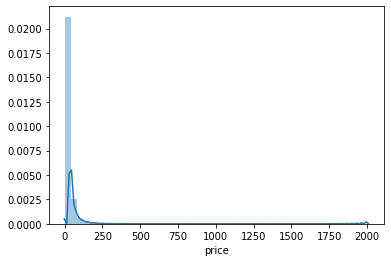

In [16]:
sns.distplot(train['price'])

### Kernel Density Estimate of "Price"

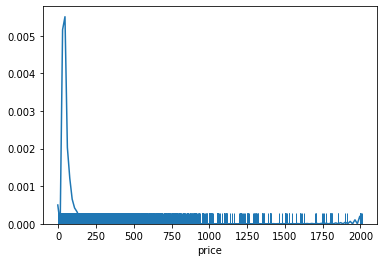

In [17]:
sns.distplot(train['price'], hist=False, rug=True);


**From the first plot, we can see that there are more products whose prices are ranging from 0 to 230 dollars and few prodcuts in range of 1800-2000. But from the second plot, we can say that there are products having prices from 250 to 2000 dollars.**

**Just added +1 to reduce the log error**

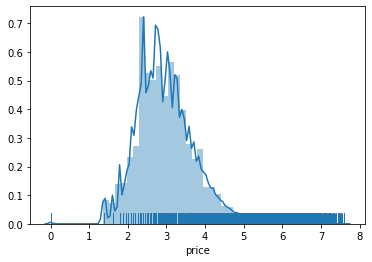

In [18]:
sns.distplot(np.log(train['price']+1), hist=True, rug=True);


In [19]:
print("There are", train[train["price"] == 0].price.size, "items with price 0.")


There are 874 items with price 0.


## Categories Feature

We have seen from the above method that there are 6327 with null values in the category_name feature

**Series containing counts of unique values**


In [15]:
train['category_name'].unique()

array(['Men/Tops/T-shirts',
       'Electronics/Computers & Tablets/Components & Parts',
       'Women/Tops & Blouses/Blouse', ..., 'Handmade/Jewelry/Clothing',
       'Vintage & Collectibles/Supplies/Ephemera',
       'Handmade/Pets/Blanket'], dtype=object)

In [16]:
train['category_name'].value_counts().shape

(1287,)

We can see that there are 1287 Unique categories available

In [17]:
train['category_name'].value_counts()[:10] 

Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Tank, Cami                                20284
Women/Tops & Blouses/Blouse                                    20284
Name: category_name, dtype: int64

6327 fields in the 'category_name' has null values.

In [18]:
train.shape

(1482535, 8)

In [19]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

## Filling missing data 

In [6]:
train=pd.read_csv('train.tsv',sep='\t')

In [7]:
def fill_missing_data(data):
    data.category_name.fillna(value = "Other/Other/Other", inplace = True)
    data.brand_name.fillna(value = "Unknown", inplace = True)
    data.item_description.fillna(value = "No description yet", inplace = True)
    return data

train = fill_missing_data(train) 

In [8]:
train[11000:11010]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
11000,11000,New Lancome Rénergie Lift & Visionnaire,1,Beauty/Skin Care/Face,Lancome,115.0,1,Bundle Lancome Rénergie Lift & Visionnaire Cx ...
11001,11001,Puma bodysuit 5pk,1,Kids/Girls 0-24 Mos/One-Pieces,Unknown,14.0,0,Brand new Puma 5 pack Size 3-6M
11002,11002,Pacifier lot advent soothie nuk gerber,3,Kids/Feeding/Pacifiers & Accessories,Avent,6.0,1,7 used pacifiers good condition 1 soothie has ...
11003,11003,Michael kors,3,Women/Women's Handbags/Shoulder Bag,Michael Kors,45.0,1,Michael kors purse some stains in the inside n...
11004,11004,LuLaRoe Perfect T GUC L,3,Women/Tops & Blouses/T-Shirts,Unknown,14.0,1,"Good used condition, worn 2-3 times but washed..."
11005,11005,Red cheetah purse,2,Women/Women's Handbags/Shoulder Bag,Neiman Marcus,8.0,1,No description yet
11006,11006,Pandora Delicate Sentiments Bow Ring,2,Women/Jewelry/Rings,PANDORA,35.0,1,PANDORA Delicate Sentiments Ring with Clear Cu...
11007,11007,Drop Hoop Earrings,2,Women/Jewelry/Earrings,Unknown,5.0,1,purchased from Dillards. Like new. Comes in bo...
11008,11008,Pink 7 plus Card Holder Phone Case,1,Women/Women's Accessories/Other,PINK,19.0,0,No description yet
11009,11009,Head and Sholders,1,Beauty/Hair Care/Shampoo Plus Conditioner,Unknown,17.0,0,4 bottles Read my profile as I will be unavail...


In [9]:
train.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

**There are no null values now in the dataset so that we can move on further**

## Splitting into Sub-Categories

In [10]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")  

In [11]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Unknown,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Unknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Unknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [12]:
train.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
general_cat          0
subcat_1             0
subcat_2             0
dtype: int64

**There are no null values in the dataset**

## Price with respect to general category

In [18]:
genreal_category=train['general_cat']
log_price=np.log(train['price']+1)

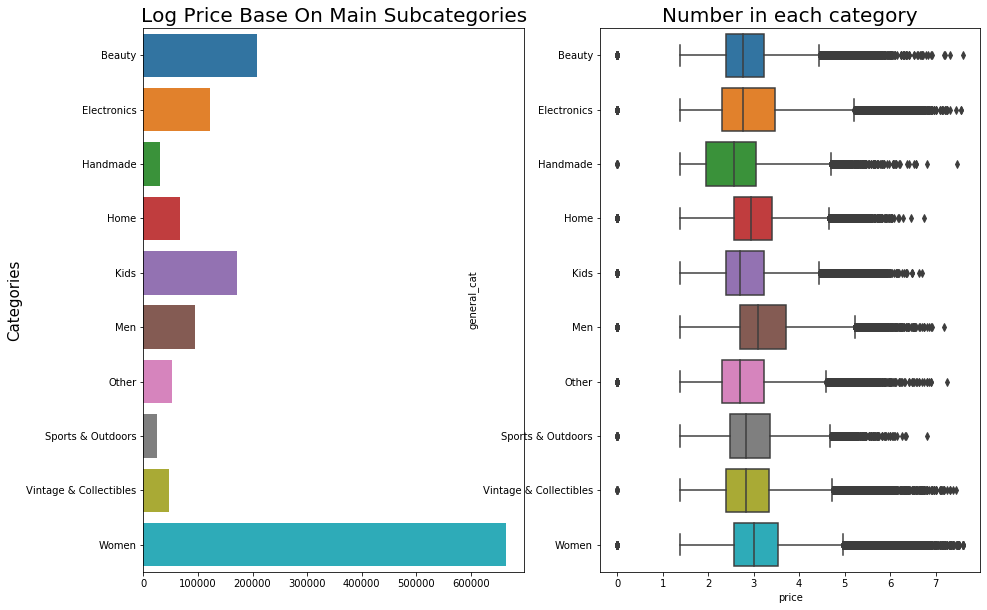

In [18]:
order = sorted(genreal_category.unique()) 
fig, ax = plt.subplots(1, 2, figsize = (15, 10)) 
sns.boxplot(x = log_price, y = genreal_category, orient = "h", order = order, ax = ax[1]) 
ax[0].set_title("Log Price Base On Main Subcategories", fontsize = 20) 
ax[0].set_ylabel("Categories", fontsize = 15) 
sns.barplot(genreal_category.value_counts().values, genreal_category.value_counts().index, order = order, ax = ax[0])
ax[1].set_title("Number in each category", fontsize = 20) 
plt.show()


In [30]:
order

['Beauty',
 'Electronics',
 'Handmade',
 'Home',
 'Kids',
 'Men',
 'Other',
 'Sports & Outdoors',
 'Vintage & Collectibles',
 'Women']

 ## Price with respect to sub- category                                               

In [25]:
subcat1=train['subcat_1']

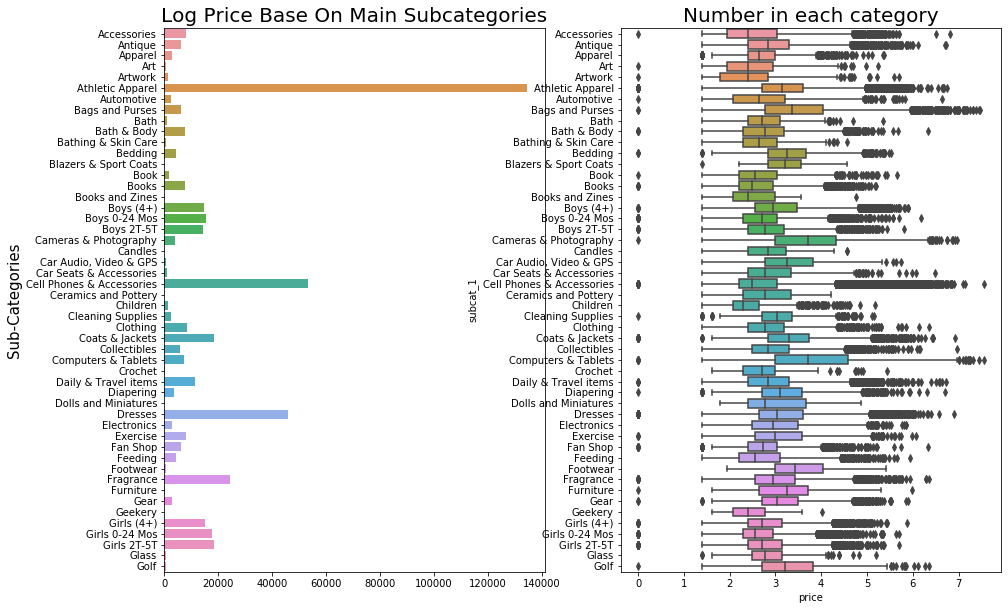

In [35]:
order1 = sorted(subcat1.unique()) 
fig, ax = plt.subplots(1, 2, figsize = (15, 10)) 
sns.boxplot(x = log_price, y = subcat1, orient = "h", order = order1[0:50], ax = ax[1]) 
ax[0].set_title("Log Price Base On Main Subcategories", fontsize = 20) 
ax[0].set_ylabel("Sub-Categories", fontsize = 15) 
sns.barplot(subcat1.value_counts().values, subcat1.value_counts().index, order = order1[0:50], ax = ax[0])    
ax[1].set_title("Number in each category", fontsize = 20)  
plt.show()

In [36]:
train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'general_cat', 'subcat_1',
       'subcat_2'],
      dtype='object')

## Variation of price with respect to Brand

In [37]:
brands = train["brand_name"].value_counts()
brands[:13]

Unknown              632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Apple                 17322
FOREVER 21            15186
Nintendo              15007
Lululemon             14558
Michael Kors          13928
American Eagle        13254
Rae Dunn              12305
Sephora               12172
Name: brand_name, dtype: int64

In [38]:
brand = brands[0:12]
log_price=np.log(train['price']+1)

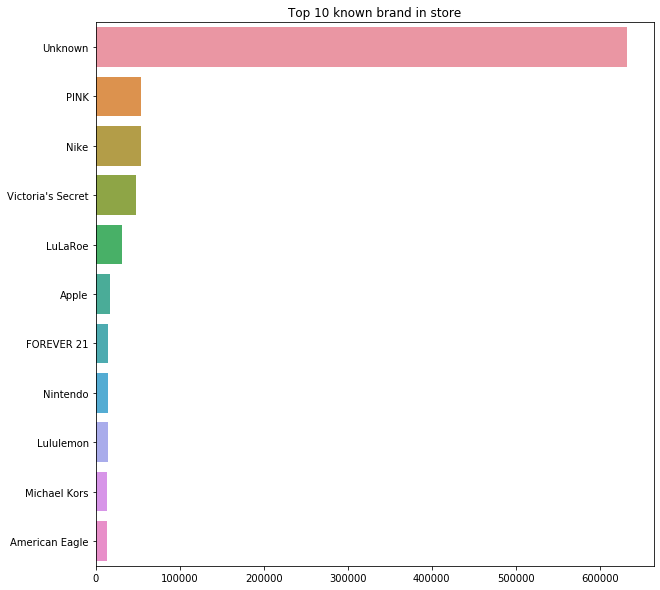

In [39]:
plt.figure(figsize = (10, 10))
sns.barplot(brand[0:11].values, brand[0:11].index)
plt.title("Top 10 known brand in store")
plt.show()

In [40]:
train[train["brand_name"] == "Unknown"].price.describe()

count    632682.000000
mean         21.133453
std          27.361260
min           0.000000
25%           9.000000
50%          14.000000
75%          24.000000
max        2000.000000
Name: price, dtype: float64

## Item description 

In [41]:
import tokenize
import nltk
from nltk import tokenize

In [42]:
train['item_description'].head()

0                                   No description yet
1    This keyboard is in great condition and works ...
2    Adorable top with a hint of lace and a key hol...
3    New with tags. Leather horses. Retail for [rm]...
4            Complete with certificate of authenticity
Name: item_description, dtype: object

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/praneethic1101/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing the text

In [54]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer("english", ignore_stopwords=True) #initialising the snowball stemmer
def cleanhtml(sentence): #function to clean the word of any html-tags
 cleanr = re.compile('<.*?>')
 cleantext = re.sub(cleanr, ' ', sentence)
 return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuationor special characters
 cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
 cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
 return cleaned
print(stop)
print('************************************')


{'what', "won't", 'does', 'but', 'further', 'will', 'while', 'the', 'before', 'in', 'few', 'more', 'yourself', 'from', 'yours', 'why', 'such', 'don', 'because', 'doesn', 'our', "should've", 'mustn', 'is', "isn't", 'all', 'so', 'if', 'at', 'wasn', 'having', 'been', 're', 'needn', 't', 'or', "shan't", 'hadn', 'ourselves', 've', "aren't", 'hers', 'than', 'just', 'aren', "hasn't", 'isn', 'about', 'most', 'over', 'y', "mightn't", "she's", "you've", "haven't", 'shan', "didn't", 'yourselves', 'it', "it's", "you're", 'after', 'i', 'until', 'then', "couldn't", 'his', 'be', 'into', 'me', 'ours', 'was', 'not', 'were', 'them', 'up', 'own', 'weren', 'o', 'during', 'myself', 'we', 'your', 'm', 'being', 'mightn', 'my', 'didn', 'won', 'has', 'she', 'to', 'nor', 'for', 'off', 'once', 's', "hadn't", 'down', 'll', "weren't", 'ma', 'again', 'through', 'both', 'had', 'should', "you'd", 'any', 'where', 'haven', 'wouldn', 'same', 'am', 'how', "shouldn't", 'that', 'an', 'd', 'have', 'other', 'too', 'out', "mu

In [ ]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in train['item_description'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (train['item_description'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(train['item_description'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [ ]:
train['desc']=final_string

In [ ]:
train['desc'].head()

In [ ]:
'''i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in test['item_description'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (test['item_description'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(test['item_description'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1'''

## Creating tokenize function

In [31]:
from nltk.tokenize import sent_tokenize,word_tokenize

In [ ]:
stop = set(stopwords.words('english'))
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

### Just checking for the non-preprocessed values

In [ ]:
'''train['tokens'] = train['item_description'].map(tokenize)
test['tokens'] = test['item_description'].map(tokenize)'''

In [ ]:
for description, tokens in zip(train['item_description'].head(),
                              train['tokens'].head()): 
    print('description:', description)
    print('tokens:', tokens)

In [ ]:
print(5)

## Tokenizing the preproccesed words

In [ ]:
train['tokens'] = train['desc'].map(tokenize)

In [52]:
print(5)

5


In [ ]:
for description, tokens in zip(train['desc'].head(15),
                              train['tokens'].head(15)): 
    print('description:', description)
    print('tokens:', tokens)
    print()

In [1]:
print(5)

5


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:

vectorizer = TfidfVectorizer(min_df=10,
                             max_features=180000,
                             tokenizer=tokenize,
                             ngram_range=(1, 2))

In [ ]:
vz=vectorizer.fit_transform(train["desc"].apply(str))

In [ ]:
all_features2=vectorizer.get_feature_names()
words2=[]
idf2=vectorizer.idf_
features=np.argsort(idf2)[::-1]
for i in features[0:30]:
    words2.append(all_features2[i])
print(words2)


In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 1200, height = 1000).generate(" ".join(words2))
plt.figure(figsize = (20, 15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#from sklearn.cluster import KMeans

In [ ]:
'''from sklearn.cluster import MiniBatchKMeans

num_clusters = 30 # need to be selected wisely
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters,
                               init='k-means++',
                               n_init=1,
                               init_size=1000, batch_size=1000, verbose=0, max_iter=1000)'''

In [ ]:
'''kmeans = kmeans_model.fit(vectorizer)
kmeans_clusters = kmeans.predict(vectorizer)
kmeans_distances = kmeans.transform(vectorizer)'''

In [ ]:
'''optimal_k = KMeans(n_clusters = 3)
p = optimal_k.fit(vz)'''

In [ ]:
'''cluster1,cluster2,cluster3=[],[],[]
for i in range(p.labels_.shape[0]):
    if clf.labels_[i] == 0:
        cluster1.append(train['desc'][i])
data=''
for i in cluster1:
    data+=str(i)

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()'''

## Shipping Feature

In [19]:
train.shipping.value_counts()


0    819435
1    663100
Name: shipping, dtype: int64

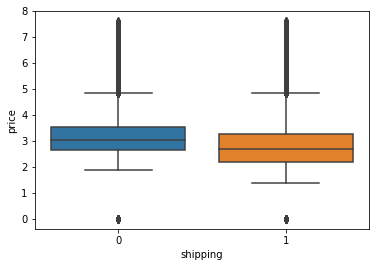

In [20]:
sns.boxplot(x = train.shipping, y = log_price, orient = "v")


In [21]:
train['log_price']=log_price

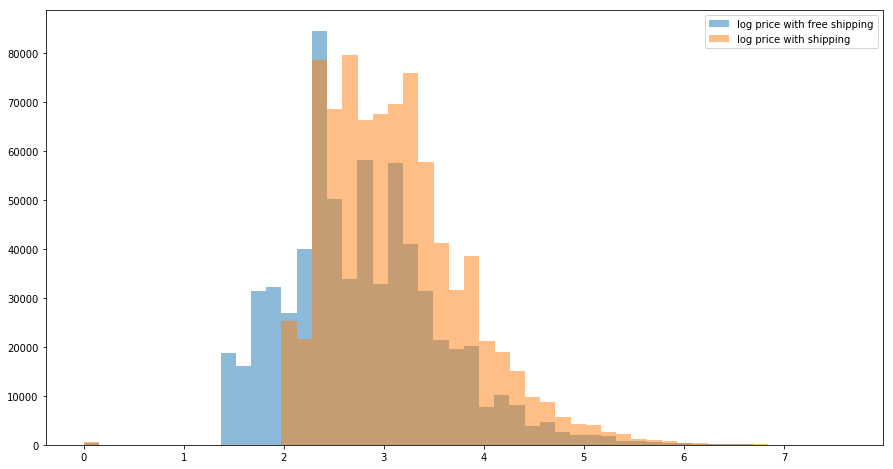

In [22]:
plt.figure(figsize = (15, 8))
plt.hist(train[train.shipping == 1].log_price, bins = 50, alpha = 0.5, label = "log price with free shipping")
plt.hist(train[train.shipping == 0].log_price, bins = 50, alpha = 0.5, label = "log price with shipping")
plt.legend(fontsize = 10)
plt.show()

## Item condition of normal points

In [23]:
def nol(data, m = 2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]


In [ ]:
chist = train.groupby(["category_name"], as_index = False).count().sort_values(by = "train_id",
                                                                               ascending = False)[0:25]

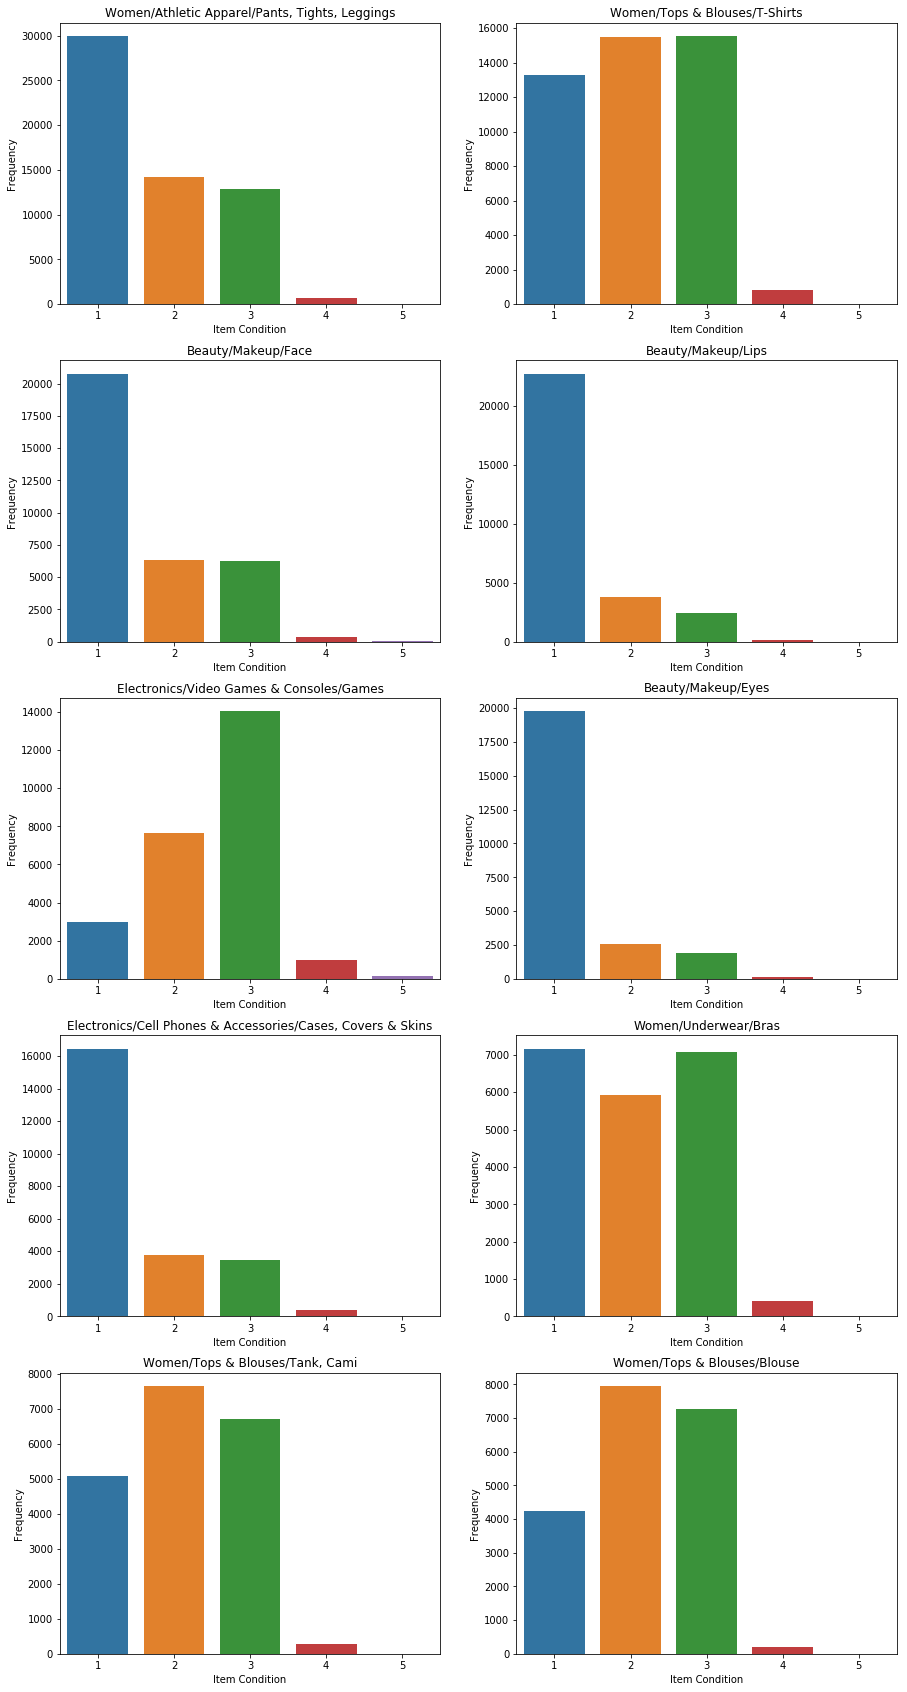

In [25]:
fig, ax = plt.subplots(5, 2, figsize = (15, 30))
k=10
for i in range(k):    
    ohist = train.iloc[(nol(train[
        train["category_name"] == chist["category_name"].values[i]
    ].price).index).values].groupby(["item_condition_id"], as_index = False).count()
    sns.barplot(x = ohist["item_condition_id"], y = ohist["train_id"], ax = ax[int(i/2)][i%2])
    ax[int(i/2)][i%2].set_title(chist["category_name"].values[i])
    ax[int(i/2)][i%2].set_xlabel("Item Condition")
    ax[int(i/2)][i%2].set_ylabel("Frequency")

In [26]:
chist1 = train.groupby(["general_cat"], as_index = False).count().sort_values(by = "train_id",
                                                                               ascending = False)[0:25]

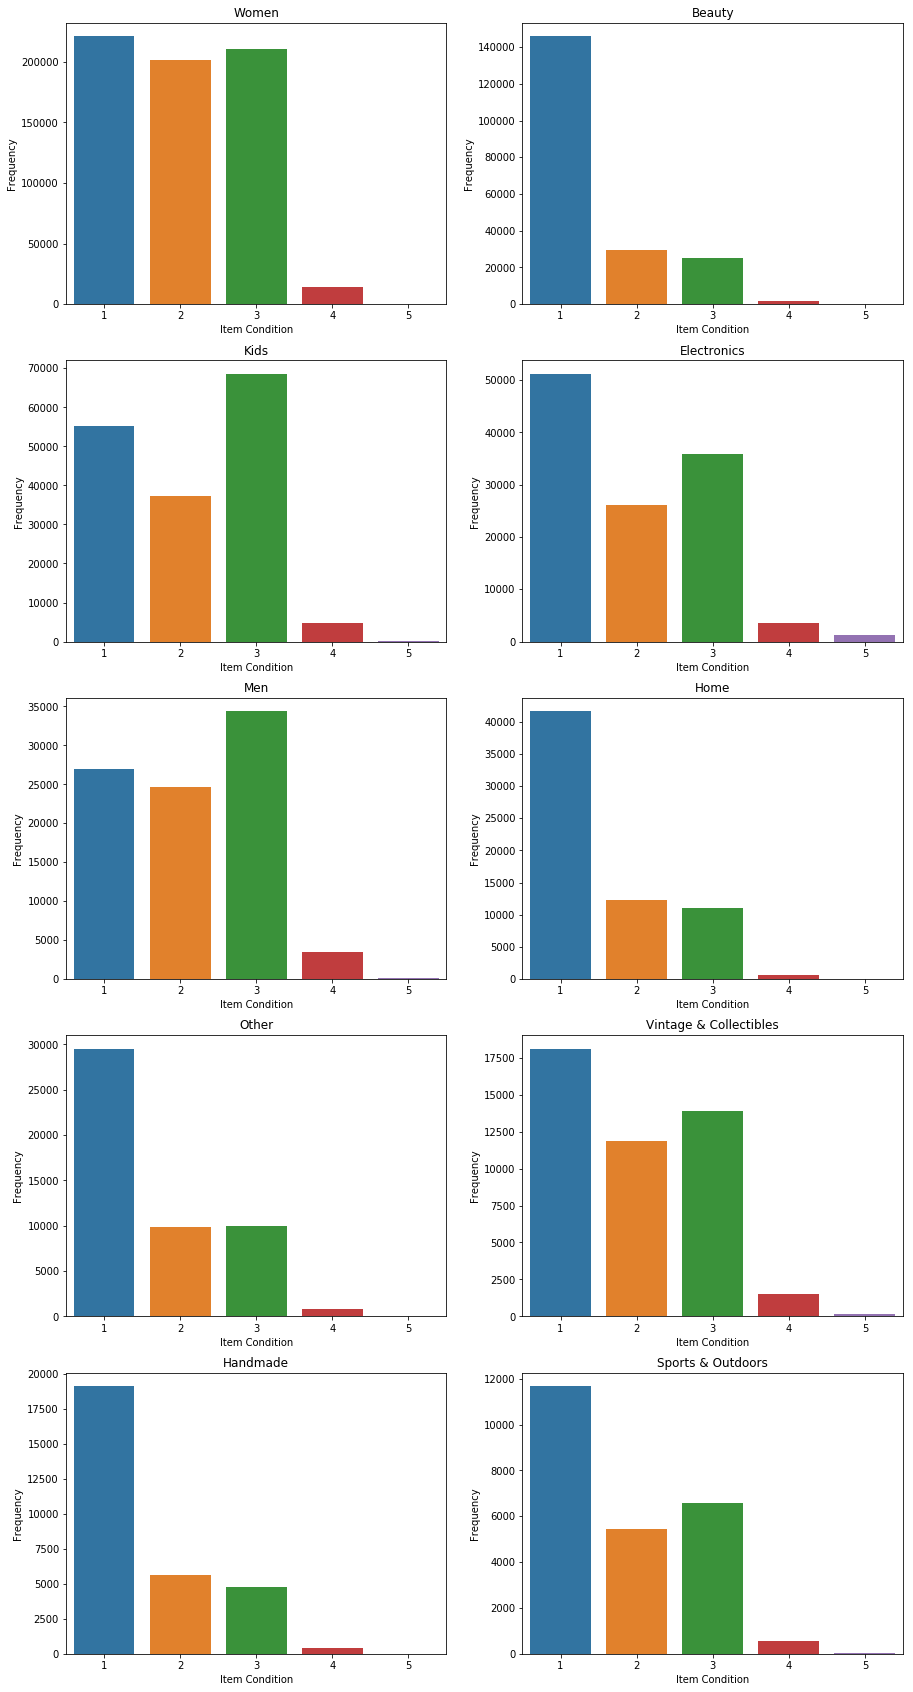

In [27]:
fig, ax = plt.subplots(5, 2, figsize = (15, 30))
k=10
for i in range(k):    
    ohist = train.iloc[(nol(train[
        train["general_cat"] == chist1["general_cat"].values[i]
    ].price).index).values].groupby(["item_condition_id"], as_index = False).count()
    sns.barplot(x = ohist["item_condition_id"], y = ohist["train_id"], ax = ax[int(i/2)][i%2])
    ax[int(i/2)][i%2].set_title(chist1["general_cat"].values[i])
    ax[int(i/2)][i%2].set_xlabel("Item Condition")
    ax[int(i/2)][i%2].set_ylabel("Frequency")

## Item condition of outlier points

In [28]:
# outliers
def ol(data, m = 3):
    return data[(data - np.mean(data)) >= m * np.std(data)]

In [29]:
chist = train.groupby(["category_name"], as_index = False).count().sort_values(by = "train_id",
                                                                               ascending = False)[0:25]

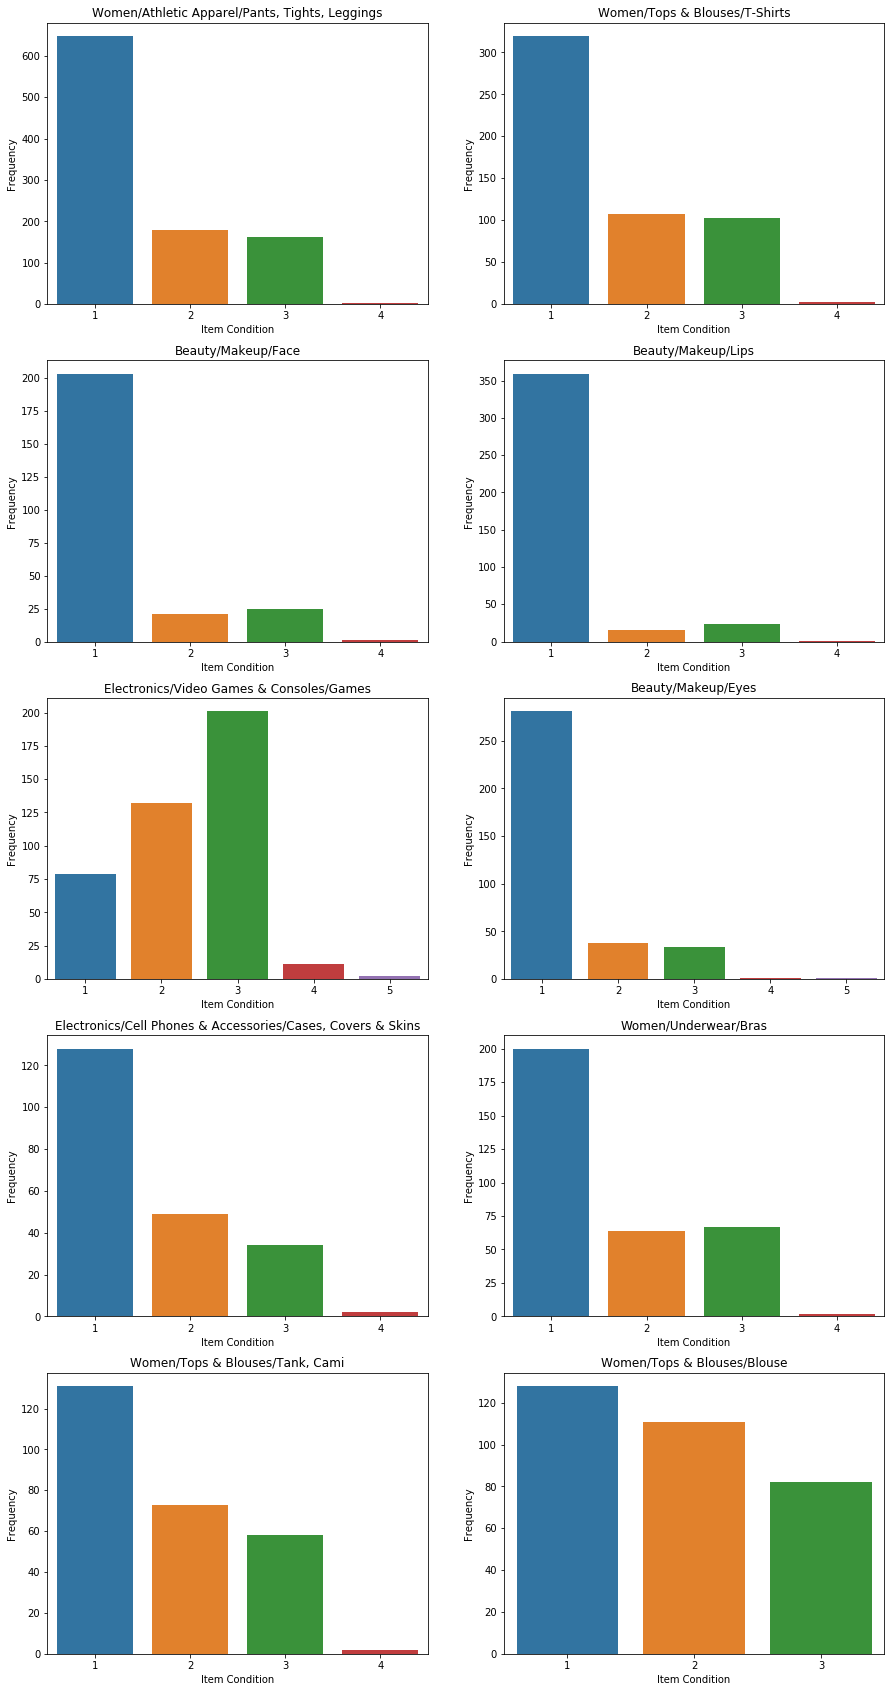

In [30]:
fig, ax = plt.subplots(5, 2, figsize = (15, 30))
k=10
for i in range(k):    
    ohist = train.iloc[(ol(train[
        train["category_name"] == chist["category_name"].values[i]
    ].price).index).values].groupby(["item_condition_id"], as_index = False).count()
    sns.barplot(x = ohist["item_condition_id"], y = ohist["train_id"], ax = ax[int(i/2)][i%2])
    ax[int(i/2)][i%2].set_title(chist["category_name"].values[i])
    ax[int(i/2)][i%2].set_xlabel("Item Condition")
    ax[int(i/2)][i%2].set_ylabel("Frequency")

## General Categories vs Item Condition

In [31]:
chist1 = train.groupby(["general_cat"], as_index = False).count().sort_values(by = "train_id",
                                                                               ascending = False)[0:25]

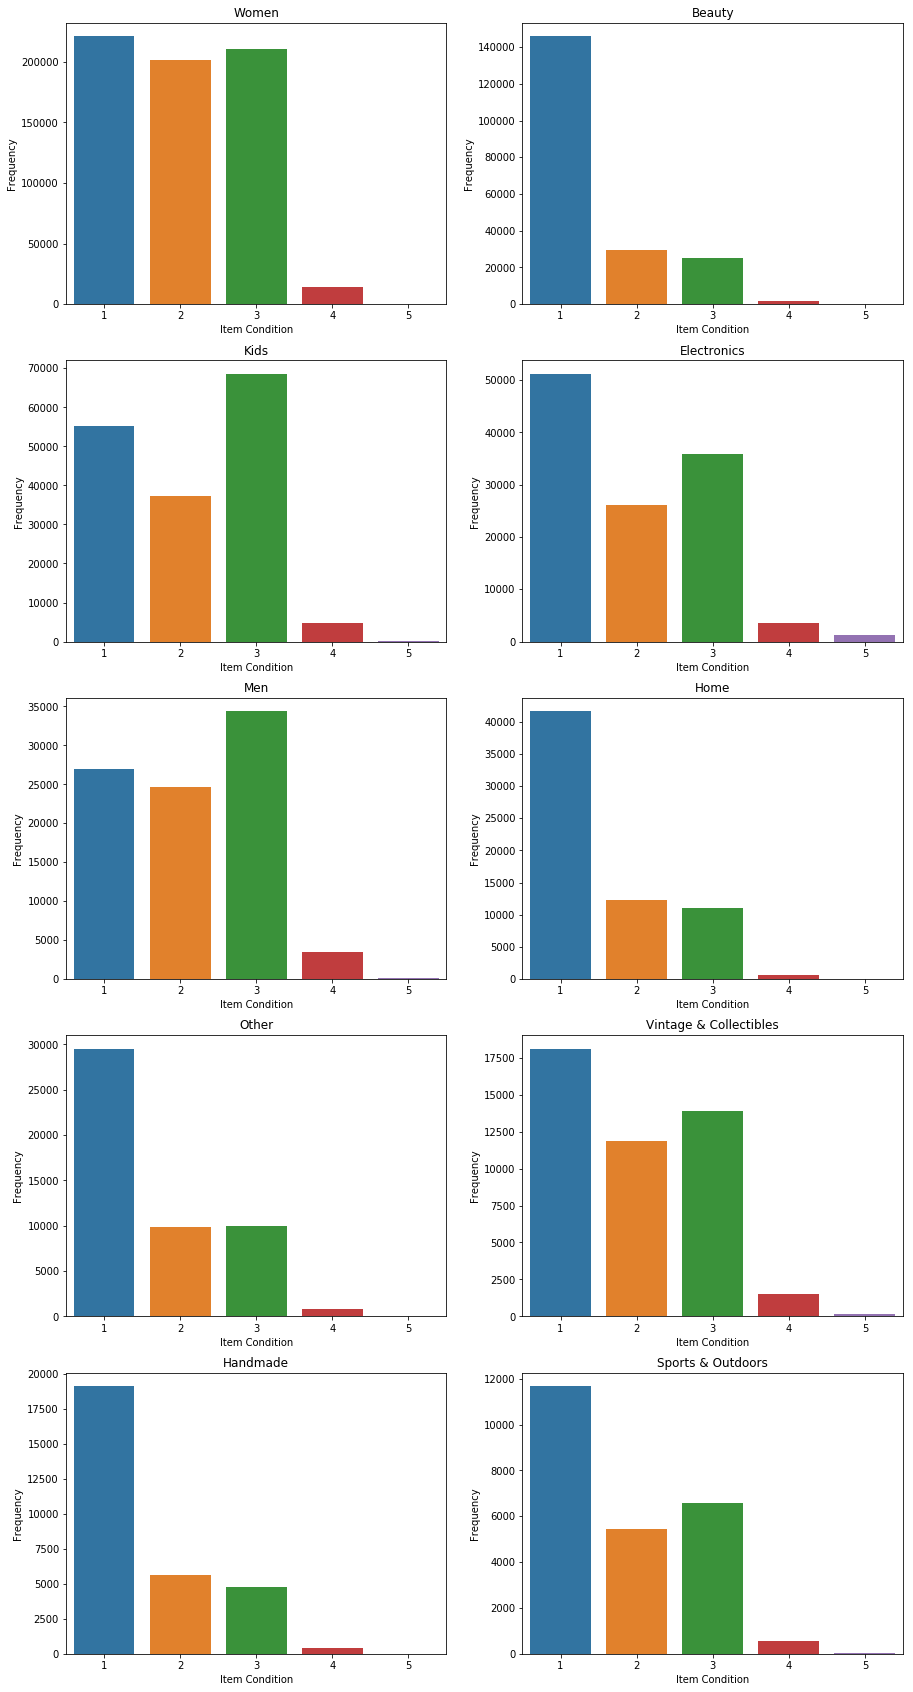

In [32]:
fig, ax = plt.subplots(5, 2, figsize = (15, 30))
k=10
for i in range(k):    
    ohist = train.iloc[(nol(train[
        train["general_cat"] == chist1["general_cat"].values[i]
    ].price).index).values].groupby(["item_condition_id"], as_index = False).count()
    sns.barplot(x = ohist["item_condition_id"], y = ohist["train_id"], ax = ax[int(i/2)][i%2])
    ax[int(i/2)][i%2].set_title(chist1["general_cat"].values[i])
    ax[int(i/2)][i%2].set_xlabel("Item Condition")
    ax[int(i/2)][i%2].set_ylabel("Frequency")

## Sub catergories normal points vs Item Condition

In [33]:
chist2 = train.groupby(["subcat_1"], as_index = False).count().sort_values(by = "train_id",
                                                                               ascending = False)[0:25]

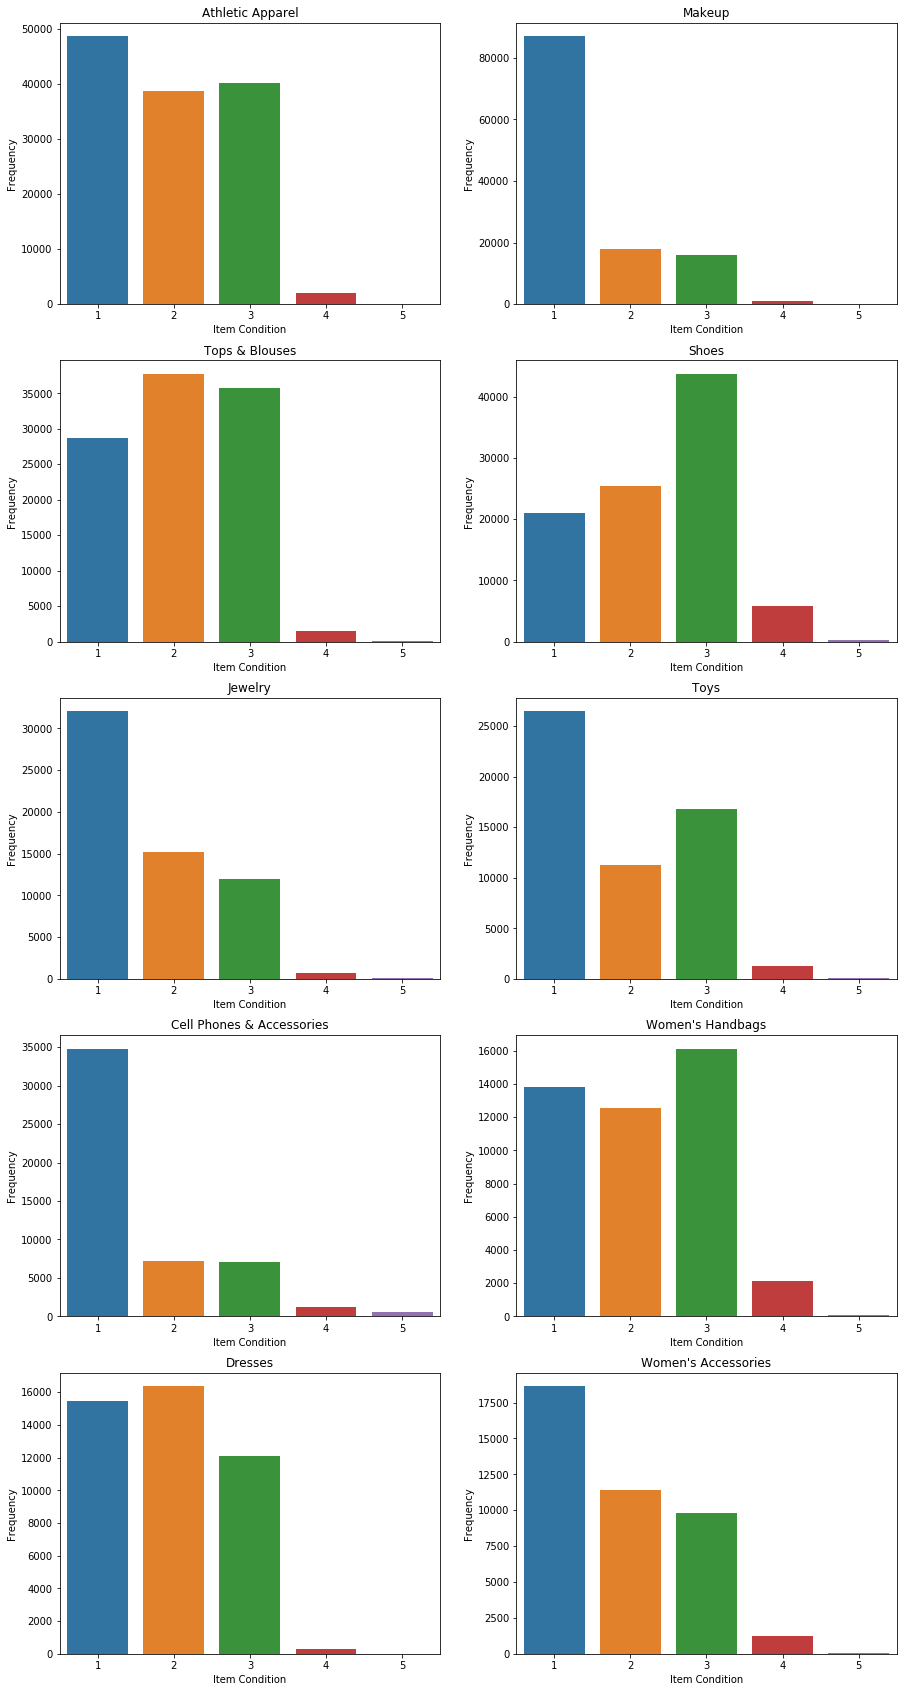

In [34]:
fig, ax = plt.subplots(5, 2, figsize = (15, 30))
k=10
for i in range(k):    
    ohist = train.iloc[(nol(train[
        train["subcat_1"] == chist2["subcat_1"].values[i]
    ].price).index).values].groupby(["item_condition_id"], as_index = False).count()
    sns.barplot(x = ohist["item_condition_id"], y = ohist["train_id"], ax = ax[int(i/2)][i%2])
    ax[int(i/2)][i%2].set_title(chist2["subcat_1"].values[i])
    ax[int(i/2)][i%2].set_xlabel("Item Condition")
    ax[int(i/2)][i%2].set_ylabel("Frequency")

## Price vs Frequency of Categories

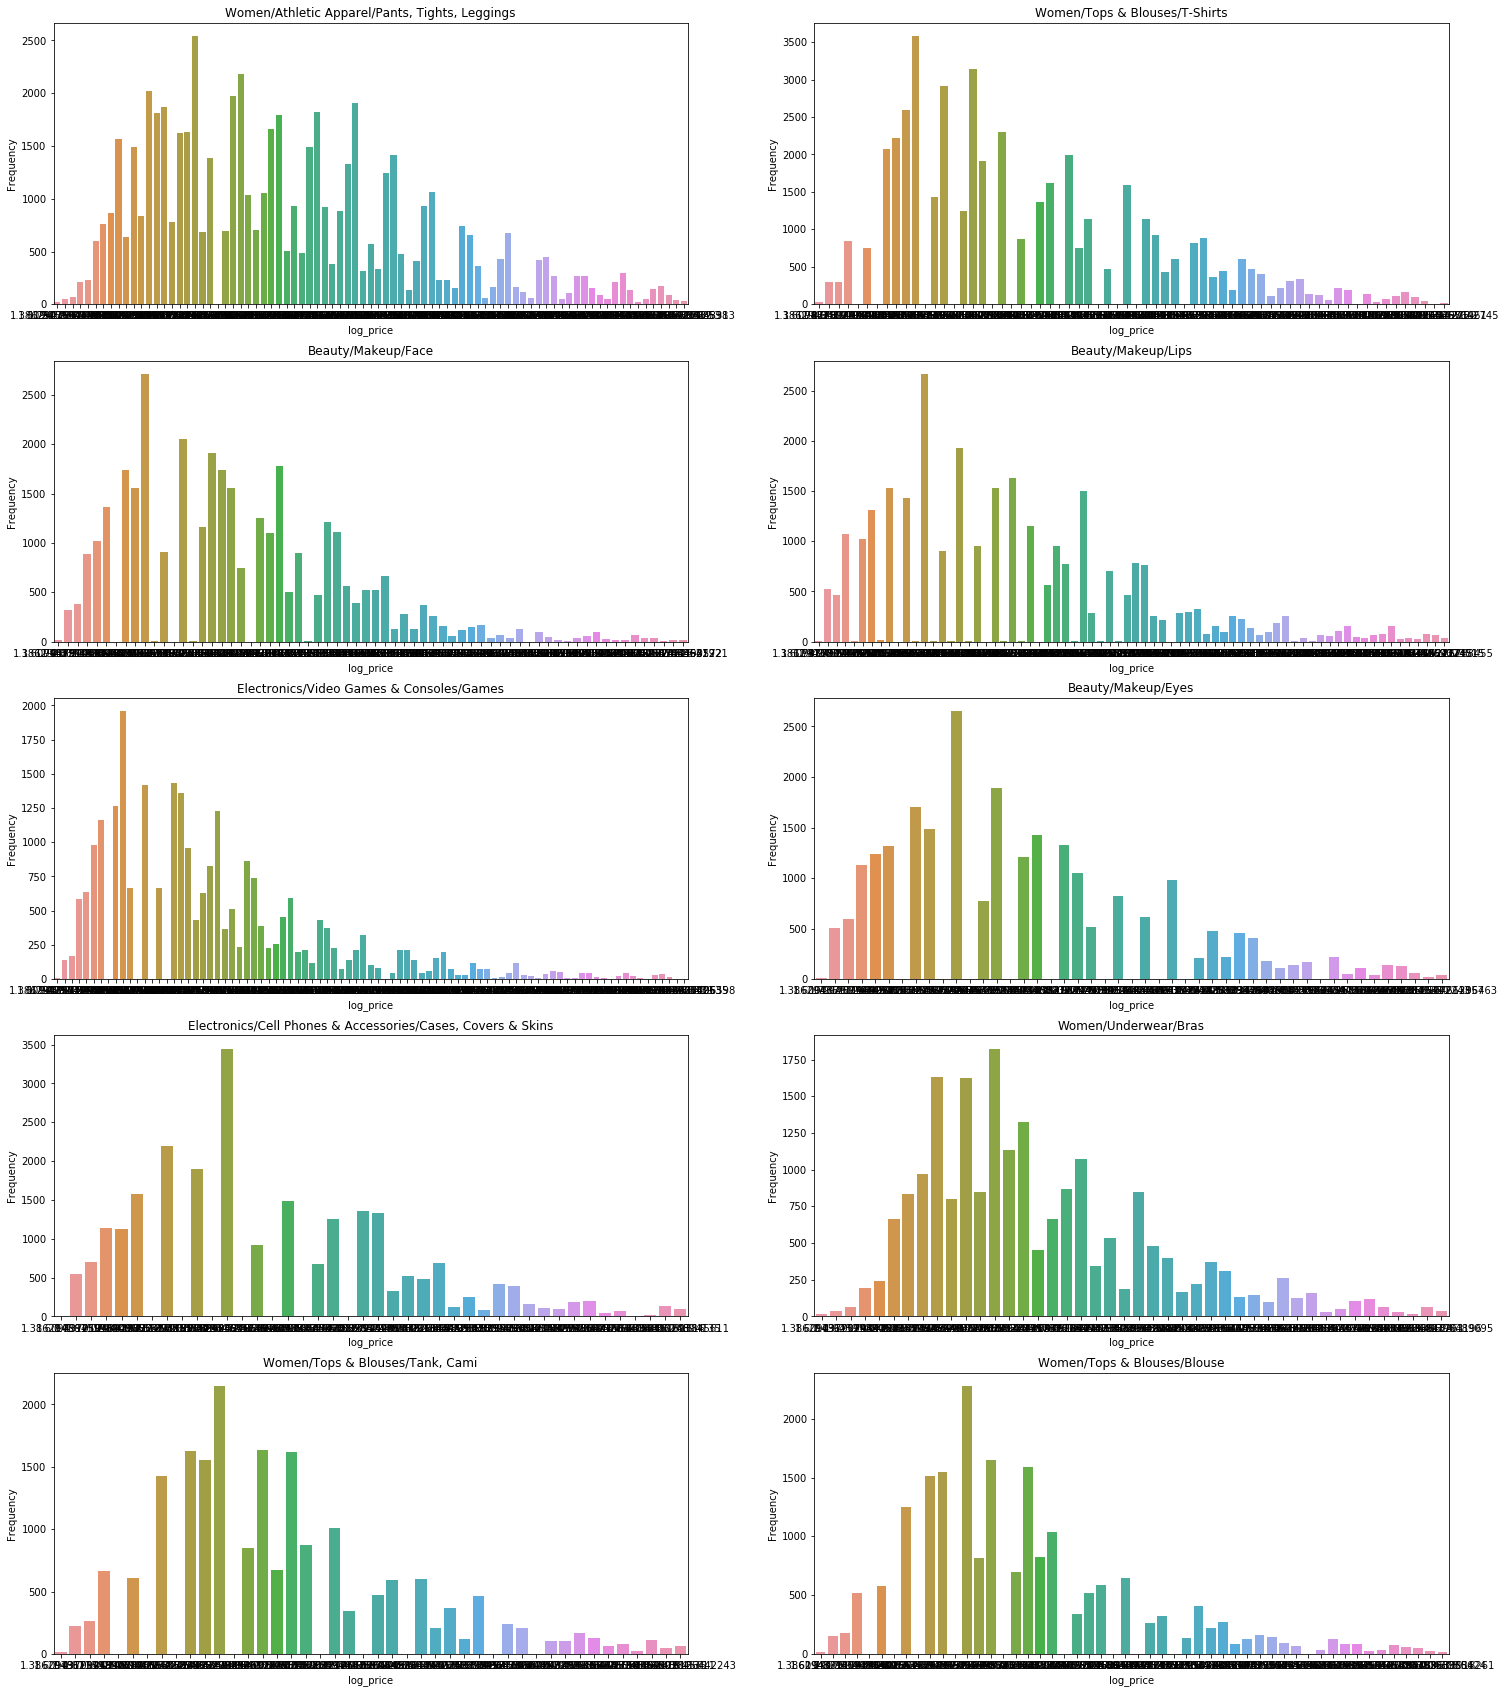

In [39]:
fig, ax = plt.subplots(5, 2, figsize = (25, 30))
k=10
for i in range(k):    
    ohist = train.iloc[(nol(train[
        train["category_name"] == chist["category_name"].values[i]
    ].price).index).values].groupby(["log_price"], as_index = False).count()
    sns.barplot(x = ohist["log_price"], y = ohist["train_id"], ax = ax[int(i/2)][i%2])
    ax[int(i/2)][i%2].set_title(chist["category_name"].values[i])
    ax[int(i/2)][i%2].set_xlabel("log_price")
    ax[int(i/2)][i%2].set_ylabel("Frequency")

## Price vs Frequency of General categories

In [83]:
chist = train.groupby(["general_cat"], as_index = False).count().sort_values(by = "train_id", ascending = False)[0:25]

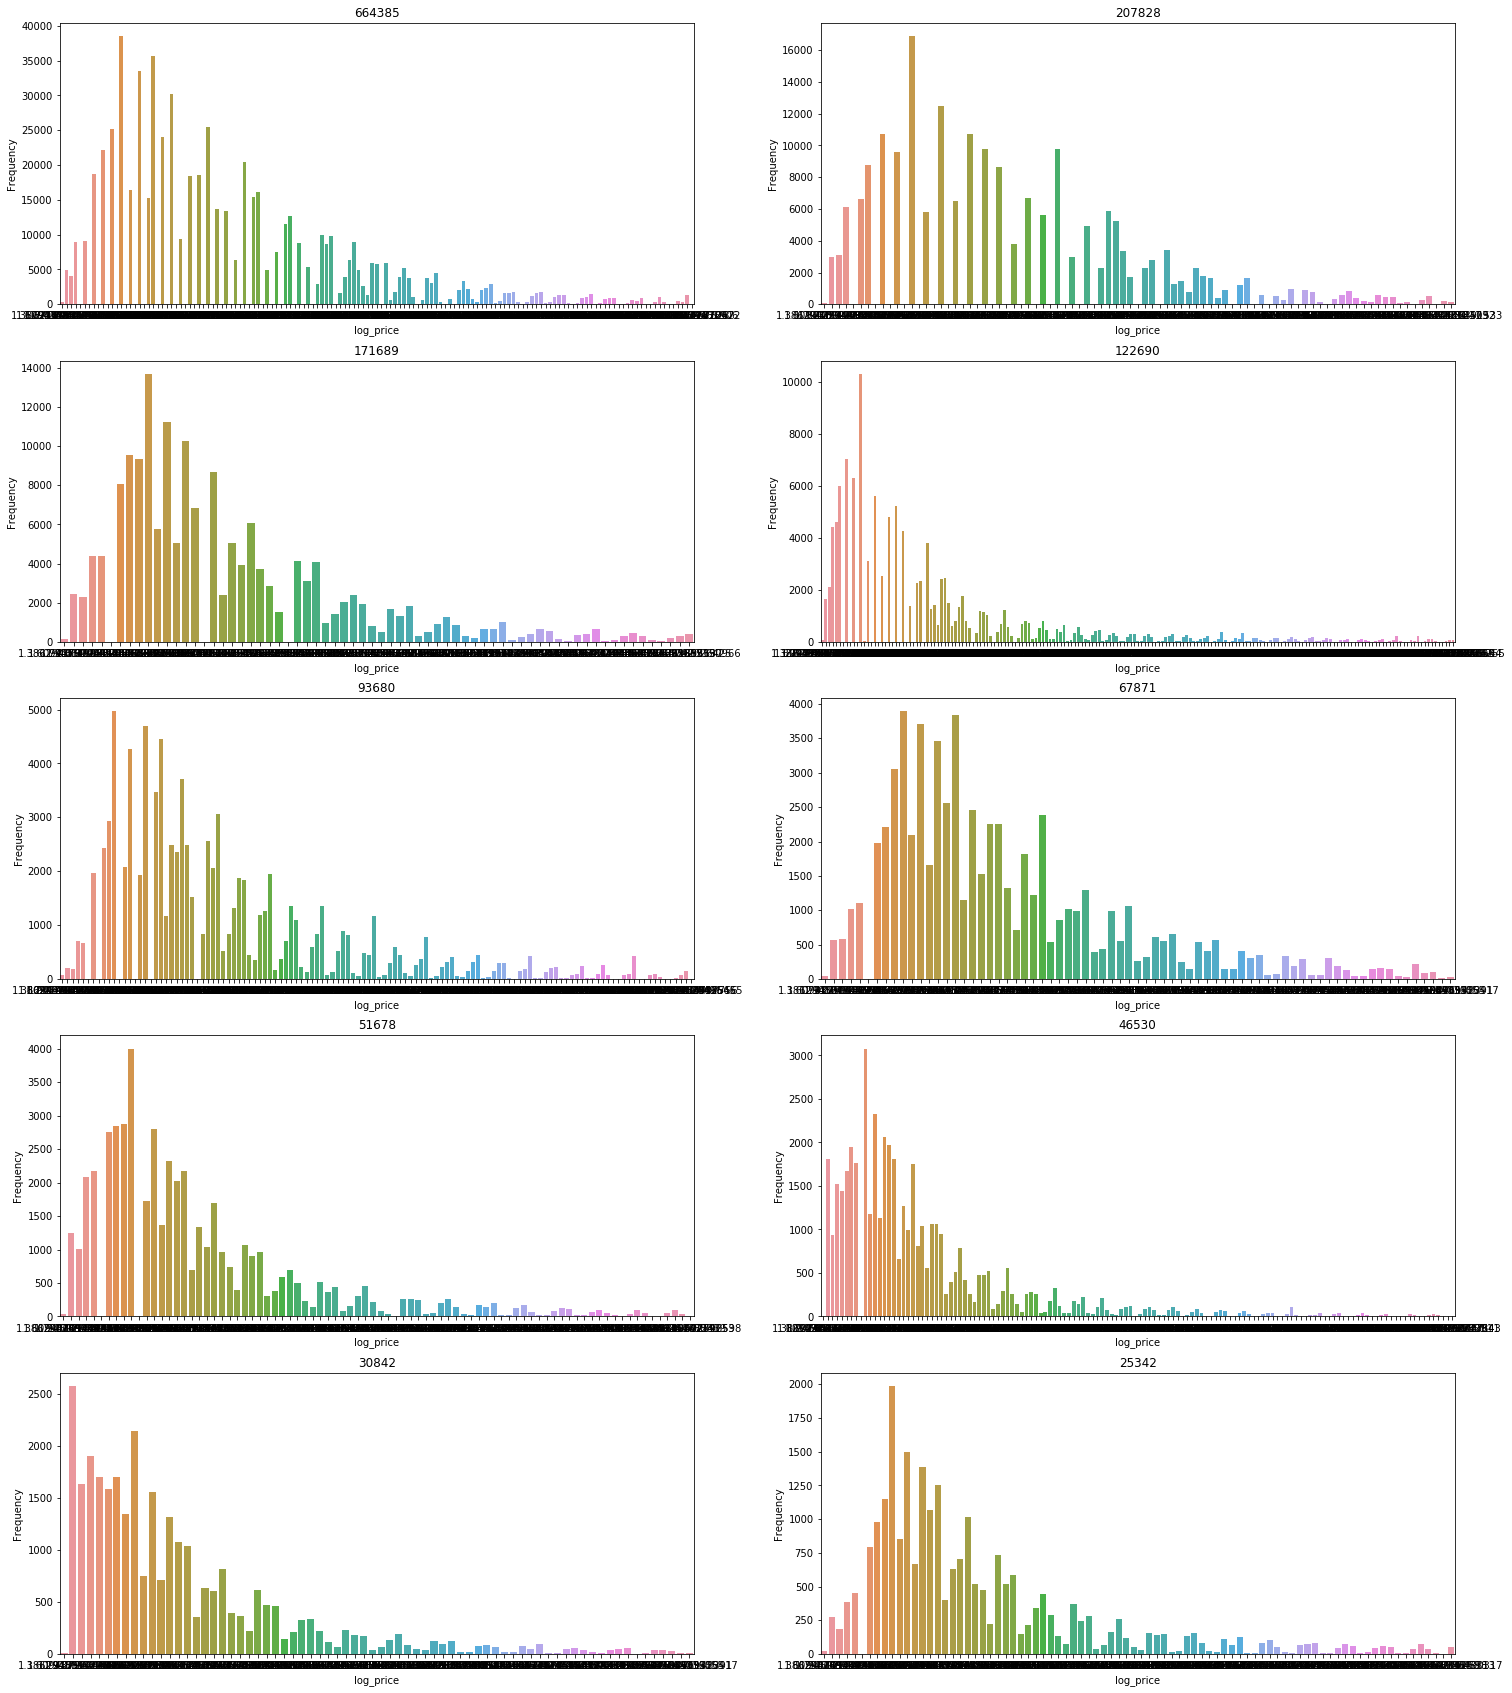

In [84]:
fig, ax = plt.subplots(5, 2, figsize = (25, 30))
k=10
for i in range(k):    
    ohist = train.iloc[(nol(train[
        train["general_cat"] == chist["general_cat"].values[i]
    ].price).index).values].groupby(["log_price"], as_index = False).count()
    sns.barplot(x = ohist["log_price"], y = ohist["train_id"], ax = ax[int(i/2)][i%2])
    ax[int(i/2)][i%2].set_title(chist["category_name"].values[i])
    ax[int(i/2)][i%2].set_xlabel("log_price")
    ax[int(i/2)][i%2].set_ylabel("Frequency")

## Price vs Frequency of Subcat_1

In [79]:
chist = train.groupby(["subcat_1"], as_index = False).count().sort_values(by = "train_id", ascending = False)[0:25]

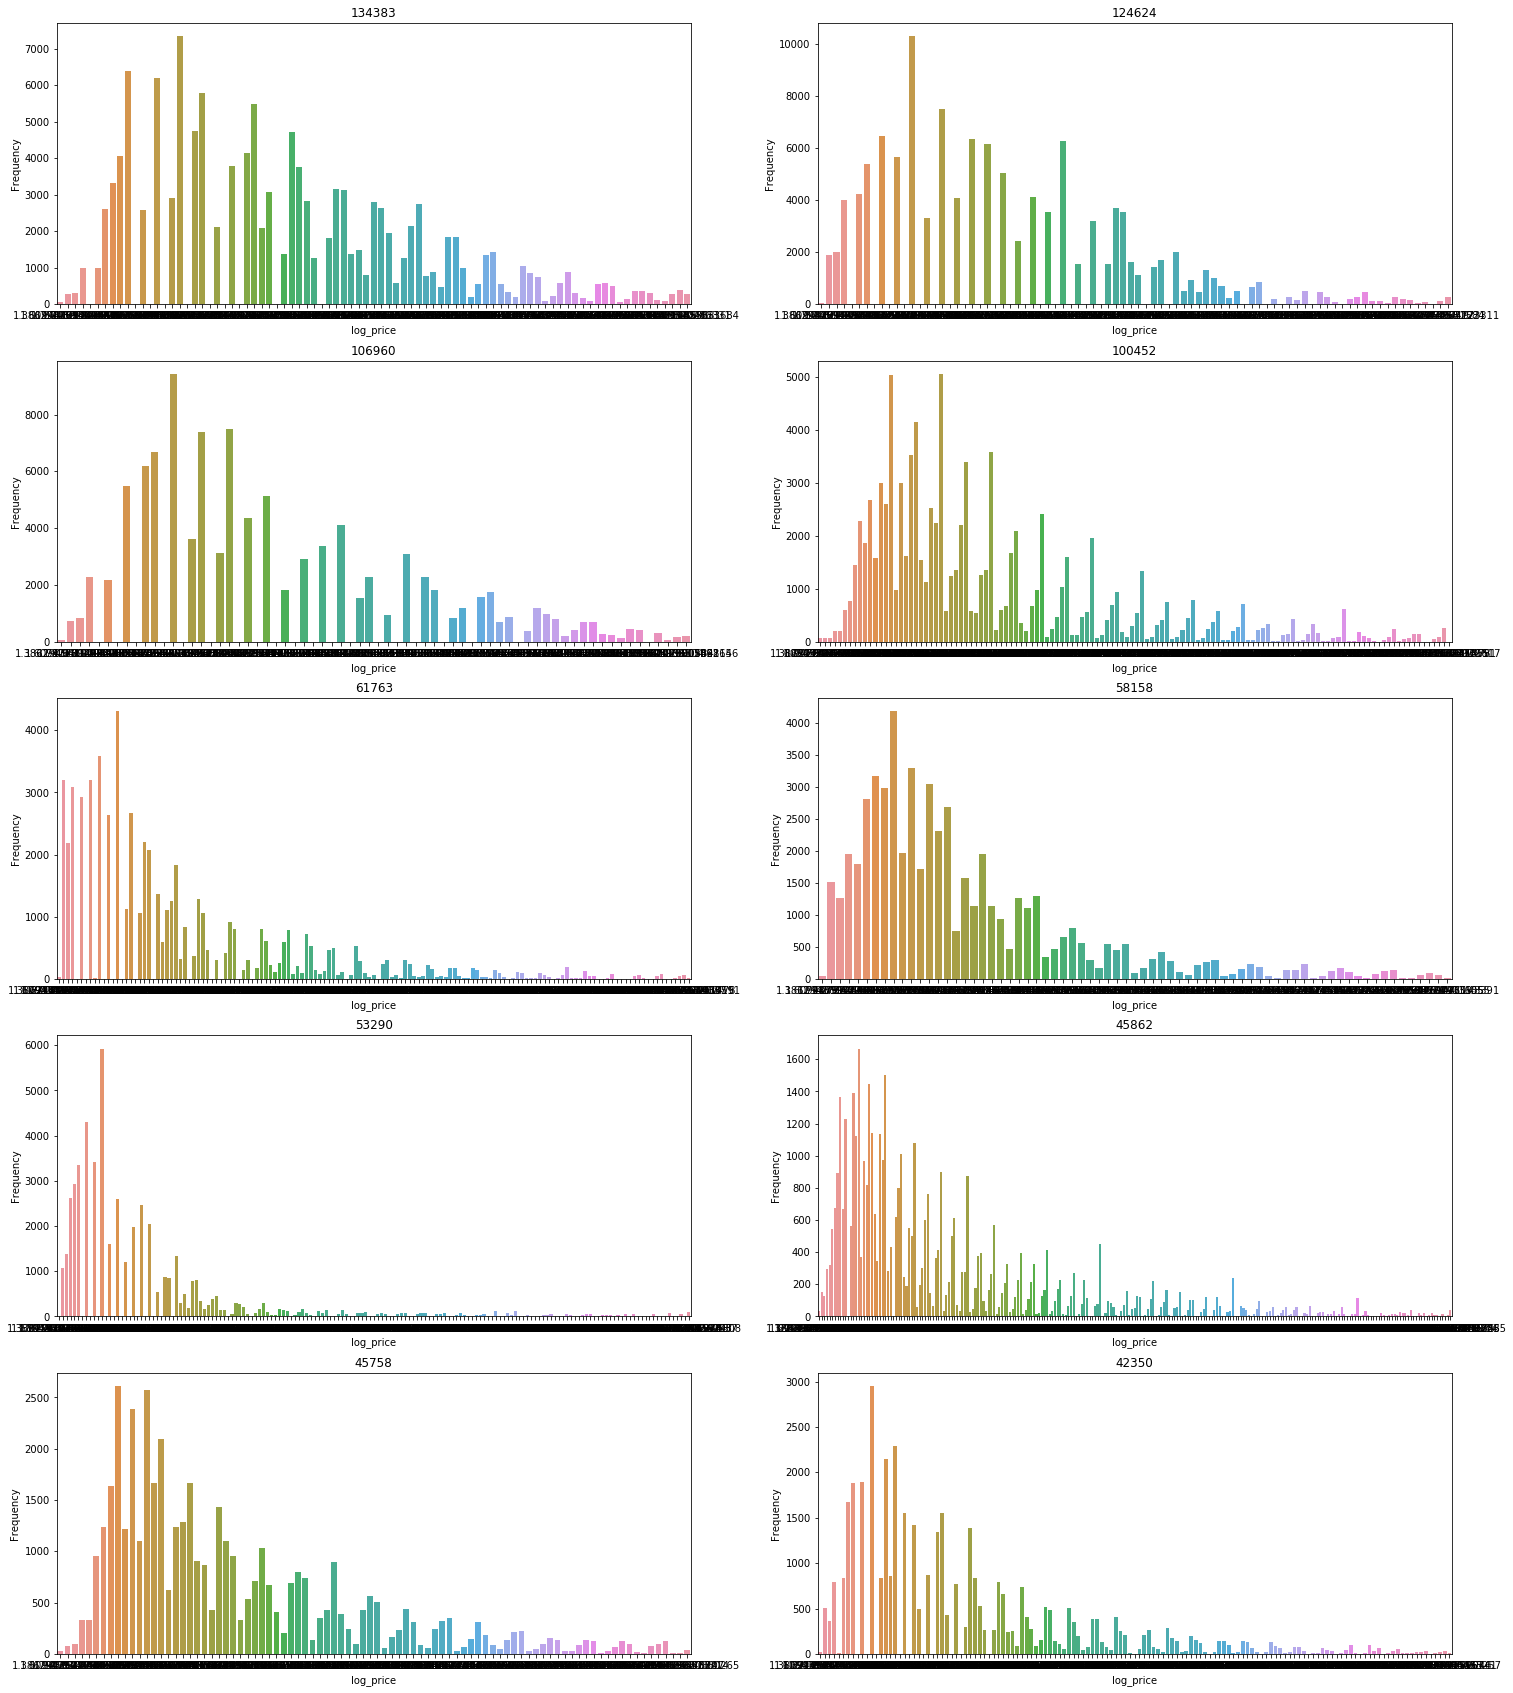

In [80]:
fig, ax = plt.subplots(5, 2, figsize = (25, 30))
k=10
for i in range(k):    
    ohist = train.iloc[(nol(train[
        train["subcat_1"] == chist["subcat_1"].values[i]
    ].price).index).values].groupby(["log_price"], as_index = False).count()
    sns.barplot(x = ohist["log_price"], y = ohist["train_id"], ax = ax[int(i/2)][i%2])
    ax[int(i/2)][i%2].set_title(chist["category_name"].values[i])
    ax[int(i/2)][i%2].set_xlabel("log_price")
    ax[int(i/2)][i%2].set_ylabel("Frequency")

## Price vs Frequency of Subcat_2

In [81]:
chist = train.groupby(["subcat_2"], as_index = False).count().sort_values(by = "train_id", ascending = False)[0:25]

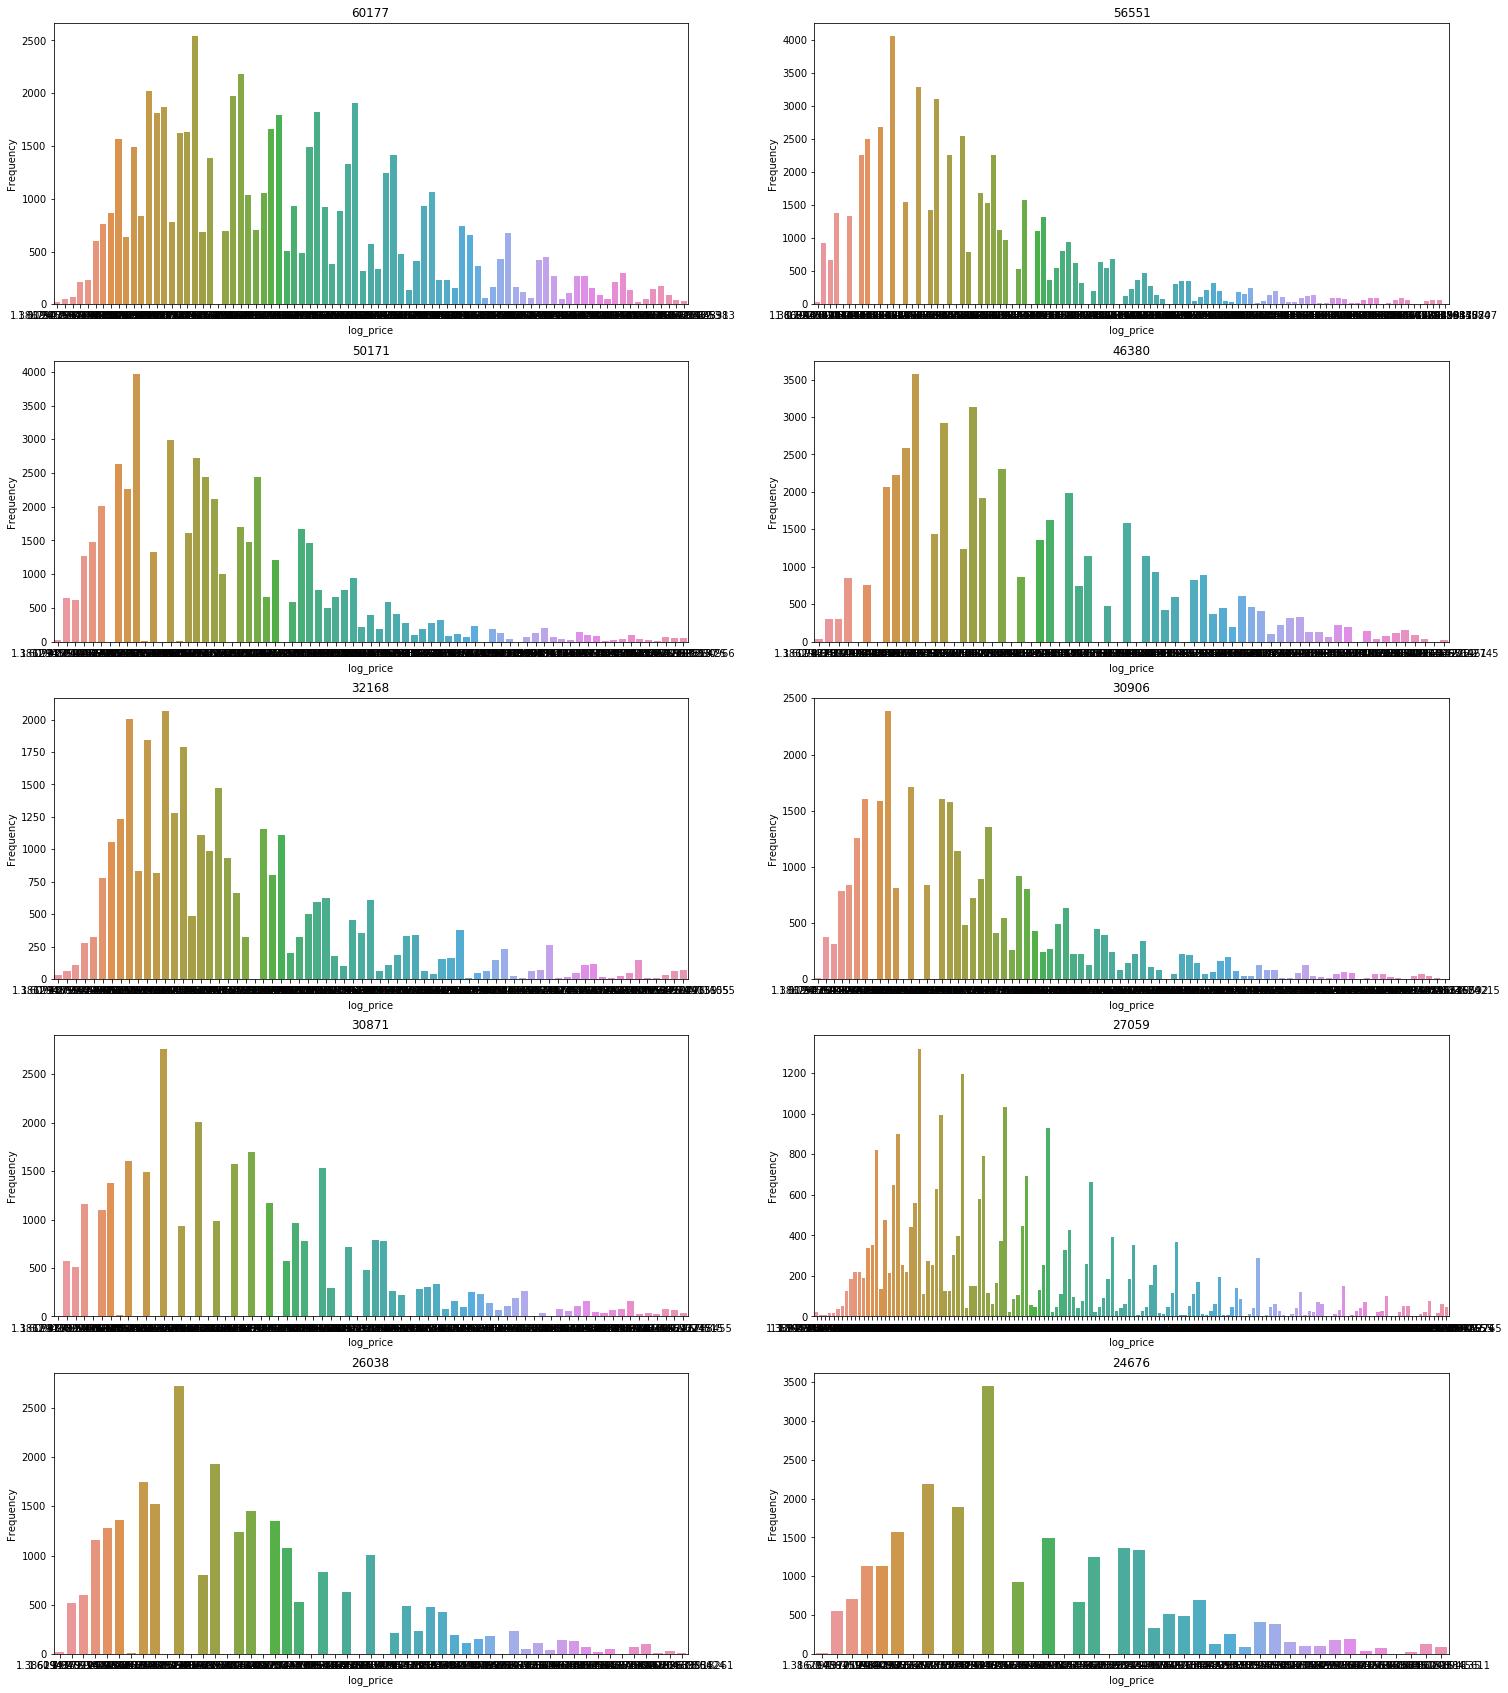

In [82]:
fig, ax = plt.subplots(5, 2, figsize = (25, 30))
k=10
for i in range(k):    
    ohist = train.iloc[(nol(train[
        train["subcat_2"] == chist["subcat_2"].values[i]
    ].price).index).values].groupby(["log_price"], as_index = False).count()
    sns.barplot(x = ohist["log_price"], y = ohist["train_id"], ax = ax[int(i/2)][i%2])
    ax[int(i/2)][i%2].set_title(chist["category_name"].values[i])
    ax[int(i/2)][i%2].set_xlabel("log_price")
    ax[int(i/2)][i%2].set_ylabel("Frequency")

In [35]:
print(5)

5


In [36]:
from sklearn.model_selection import train_test_split 

## Final Training

In [ ]:
#Length of the descritption

lenofdesc=[]
for i in train['desc']:
    lenofdesc.append(len(i))

In [ ]:
lenofdesc[0:10]

In [ ]:
train['desclength']=lenofdesc

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

**Taking  both X (as train2) and y variables**

In [ ]:
train2=train     
y=np.array(train2['price'])

In [ ]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer("english", ignore_stopwords=True) #initialising the snowball stemmer
def cleanhtml(sentence): #function to clean the word of any html-tags
 cleanr = re.compile('<.*?''>')
 cleantext = re.sub(cleanr, ' ', sentence)
 return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuationor special characters
 cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
 cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
 return cleaned
print(stop)
print('************************************')


In [ ]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in train2['name'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (train2['name'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(train2['name'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1 

In [ ]:
train2['name'].head(25)

In [ ]:
train2['cname']=final_string

In [ ]:
train2['cname'].head()

In [ ]:
from scipy import sparse

In [ ]:
#x_dummies= sparse.csr_matrix(pd.get_dummies(train2[['shipping','item_condition_id']],sparse=True).values)

In [ ]:
#train2['dummies']=x_dummies

In [ ]:
train2.columns

In [ ]:
vectorizer = TfidfVectorizer(min_df=10,lowercase=True)
desc = vectorizer.fit_transform(train2['desc']) 
desc.shape

In [ ]:
all_features2=vectorizer.get_feature_names()
words2=[]
idf2=vectorizer.idf_
features=np.argsort(idf2)[::-1]
for i in features[100:]:
    words2.append(all_features2[i])
len(words2)

In [ ]:
words2

In [ ]:
train2['words']=words2

### Splitting into train,cv and test

In [ ]:
x_train,x_cv,y_train,y_cv=train_test_split(train2,y,test_size=0.2,random_state=42)
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.2,random_state=42)

In [ ]:
x_train.columns

## Number of words in Brand and Description

In [ ]:
from collections import Counter 

In [ ]:
train['brand_name']
vect = CountVectorizer(ngram_range=(1,3),lowercase=True) 
brandvec = vect.fit_transform(x_train['brand_name'])
print(len(vect.get_feature_names()))

In [ ]:
words= vect.get_feature_names()
type(words)

In [ ]:
len(words)

In [ ]:
train['desc']
vect1 = CountVectorizer(ngram_range=(1,3),lowercase=True) 
desc1 = vect1.fit_transform(x_train['subcat_2'])
print(len(vect1.get_feature_names()))

In [ ]:
dwords=vect1.get_feature_names()
len(dwords)

In [ ]:
train['desc']
vect1 = CountVectorizer(ngram_range=(1,2),lowercase=True) 
desc1 = vect1.fit_transform(x_train['desc'])
pff=vect1.get_feature_names()
len(pff)

In [ ]:
train['desc']
vect1 = CountVectorizer() 
subcat = vect1.fit_transform(train['subcat_2'])
subc1=vect1.get_feature_names()
len(subc1)

In [ ]:
#counter = Counter(words)
#print(counter)

In [ ]:
train2.columns

In [ ]:
from sklearn.preprocessing import LabelBinarizer

## Featurization (Vectorizing the text data)

In [ ]:
vectorizer = CountVectorizer(min_df=10,lowercase=True) 
brandvec = vectorizer.fit_transform(x_train['brand_name'])
brandvec1 = vectorizer.transform(x_cv['brand_name'])
brandvec2 = vectorizer.transform(x_test['brand_name'])

In [ ]:
vectorizer = CountVectorizer(min_df=10,lowercase=True)
gencatvec = vectorizer.fit_transform(x_train['general_cat'])
gencatvec1 = vectorizer.transform(x_cv['general_cat'])
gencatvec2 = vectorizer.transform(x_test['general_cat'])

In [ ]:
vectorizer = CountVectorizer(min_df=10,lowercase=True)
subcatvec = vectorizer.fit_transform(x_train['subcat_1'])
subcatvec11 = vectorizer.transform(x_cv['subcat_1'])
subcatvec12 = vectorizer.transform(x_test['subcat_1'])

In [ ]:
vectorizer = CountVectorizer(min_df=10,lowercase=True)
subcatvec2 = vectorizer.fit_transform(x_train['subcat_2'])
subcatvec21 = vectorizer.transform(x_cv['subcat_2'])      
subcatvec212 = vectorizer.transform(x_test['subcat_2'])

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),min_df=10,max_df=10000,max_features=5000,lowercase=True) 
desc = vectorizer.fit_transform(x_train['desc']) 
desc1 = vectorizer.transform(x_cv['desc']) 
desc2 = vectorizer.transform(x_test['desc'])

In [ ]:
print(len(vectorizer.get_feature_names()))

**Shape of train data**

In [ ]:
print(brandvec.shape)       
print(gencatvec.shape)
print(subcatvec.shape)
print(subcatvec2.shape)
print(desc.shape)
print(name.shape)

**Shape of cv data**

In [ ]:
print(gencatvec1.shape)
print(subcatvec11.shape)
print(subcatvec21.shape)
print(desc1.shape)
print(name1.shape)

**Shape of test data**

In [ ]:
print(gencatvec2.shape)
print(subcatvec12.shape)
print(subcatvec212.shape)
print(desc2.shape)
print(name2.shape)

**Transforming to sparse matrix**

In [ ]:
from sklearn.preprocessing import Normalizer
from scipy import sparse

In [ ]:
normalizer=Normalizer()

normalizer.fit(x_train['shipping'].values.reshape(-1,1))
ship1=normalizer.transform(x_train['shipping'].values.reshape(-1,1))
ship=np.array(ship1.astype('float32')) 
shipsp=sparse.csr_matrix(ship)  


In [ ]:
shipsp.shape

In [ ]:
normalizer=Normalizer()

normalizer.fit(x_train['desclength'].values.reshape(-1,1))
dl1=normalizer.transform(x_train['desclength'].values.reshape(-1,1))
dl=np.array(ship1.astype('float32'))
dlsp=sparse.csr_matrix(dl)  

In [ ]:
normalizer=Normalizer()

normalizer.fit(x_train['item_condition_id'].values.reshape(-1,1)) 
itemcond1= normalizer.transform(x_train['item_condition_id'].values.reshape(-1,1))
itemcond=np.array(itemcond1.astype('float32'))
itemcondsp=sparse.csr_matrix(itemcond)  


itemcondsp.shape

In [ ]:
x_train['tokens']

**Combining all the required features by horizontal stacking**

In [ ]:
from scipy.sparse import hstack
x_final_train=hstack((brandvec,gencatvec,subcatvec,subcatvec2,desc,shipsp,itemcondsp,dlsp,name)) #its working 

In [ ]:
x_final_train.shape

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

## Hyperparameter tuning with Randomized Search 

In [ ]:
grid={
 'max_depth': [30,40,45],  
 'n_estimators': [4000,4500],
 'learning_rate':[0.1,0.2],  
     }

## Using LGBMRegressor Model

In [ ]:
%%time
clf= LGBMRegressor(colsample_bytree=0.8,subsample=0.9,min_child_samples=50) 
rf_random = GridSearchCV(estimator = clf, param_grid = grid, 
                               cv=3, verbose=1)
rf_random.fit(x_final_train,y_train,verbose=True)

In [ ]:
bestpar=rf_random.best_params_
bestpar

In [ ]:
clf=LGBMRegressor(booster='gbtree' ,max_depth=30,n_estimators=5000)
clf.fit(x_final_train,y_train)
predt=clf.predict(x_final_train)

**Defining RMSLE function**

In [ ]:
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<=0 or real[x]<=0: #check for negative values
            continue 
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

**RMSLE with respect to train data**

In [ ]:
print(rmsle(y_train,predt))

### Converting cv data to sparsre matrix 

In [ ]:
from scipy import sparse
from scipy.sparse import hstack

In [ ]:
normalizer=Normalizer()

normalizer.fit(x_cv['shipping'].values.reshape(-1,1))
ship1=normalizer.transform(x_cv['shipping'].values.reshape(-1,1))
ship=np.array(ship1.astype('float32'))
shipsp1=sparse.csr_matrix(ship)  


In [ ]:
shipsp.shape

In [ ]:
normalizer=Normalizer()

normalizer.fit(x_cv['desclength'].values.reshape(-1,1))
dl1=normalizer.transform(x_cv['desclength'].values.reshape(-1,1)) 
dl=np.array(dl1.astype('float32'))
dlsp1=sparse.csr_matrix(dl)  

In [ ]:
normalizer=Normalizer()

normalizer.fit(x_cv['item_condition_id'].values.reshape(-1,1))
itemcond1= normalizer.transform(x_cv['item_condition_id'].values.reshape(-1,1))
itemcond=np.array(itemcond1.astype('float32'))
itemcondsp1=sparse.csr_matrix(itemcond)  


itemcondsp1.shape

In [ ]:
token=np.array(x_cv['tokens'].astype('float32'))
tokensp=sparse.csr_matrix(token)  
tokensp1=tokensp.reshape(-1, 1)
tokensp1.shape

**Combining all the features of cv data by horizontal stacking**

In [ ]:
from scipy.sparse import hstack
x_final_cv=hstack((brandvec1,gencatvec1,subcatvec11,subcatvec21,desc1,shipsp1,itemcondsp1,dlsp1,name1)) #its working 

In [ ]:
x_final_train.shape


In [ ]:
x_final_cv.shape

## Checking with respect to train and cv data

In [ ]:
pred=clf.predict(x_final_cv)

In [ ]:
pred

**RMSLE with respect to cv data**

In [ ]:
print(rmsle(y_cv,pred))

### Sparse matrix of test data

In [ ]:
normalizer=Normalizer()

normalizer.fit(x_test['shipping'].values.reshape(-1,1))
ship1=normalizer.transform(x_test['shipping'].values.reshape(-1,1))
ship=np.array(ship1.astype('float32'))
shipsp2=sparse.csr_matrix(ship)  


In [ ]:
normalizer=Normalizer()

normalizer.fit(x_test['desclength'].values.reshape(-1,1))
dl1=normalizer.transform(x_test['desclength'].values.reshape(-1,1))
dl=np.array(dl1.astype('float32'))
dlsp2=sparse.csr_matrix(dl)  

In [ ]:
normalizer=Normalizer()

normalizer.fit(x_test['item_condition_id'].values.reshape(-1,1))
itemcond1= normalizer.transform(x_test['item_condition_id'].values.reshape(-1,1))
itemcond=np.array(itemcond1.astype('float32'))
itemcondsp2=sparse.csr_matrix(itemcond)  


itemcondsp2.shape

In [ ]:
token=np.array(x_test['tokens'].astype('float32'))
tokensp=sparse.csr_matrix(token)  
tokensp2=tokensp.reshape(-1, 1)
tokensp2.shape

**Combining all the features of test data by horizontal stacking**

In [ ]:
x_final_train.shape

In [ ]:
x_final_test=hstack((brandvec2,gencatvec2,subcatvec12,subcatvec212,desc2,shipsp2,itemcondsp2,dlsp2,name2))

In [ ]:
pred3=clf.predict(x_final_test)

**Defining RMSLE function**

In [ ]:
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<=0 or real[x]<=0: #check for negative values
            continue 
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

**RMSLE with respect to both train and test data**

In [ ]:
print(rmsle(y_train,predt))

In [ ]:
print(rmsle(y_test,pred3))

**We are given two stages to test the data. In the first stage we are given with test.tsv to predict the predict the prices. In the second stage we are given with teststg2.tsv which is the final stage to get the predict the prices. As this late submission, we are given to test only with respect to stage2 i.e teststg2.tsv** 

## This is the test data from stage 1 which is not considered by the kaggle kernel. 

In [64]:
sample = pd.concat([train.drop(columns=["price"], axis=0), test], axis=0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [65]:
sample.head()

,brand_name,category_name,desc,general_cat,item_condition_id,item_description,name,shipping,subcat_1,subcat_2,test_id,train_id
0,Unknown,Men/Tops/T-shirts,b'descript yet',Men,3,No description yet,MLB Cincinnati Reds T Shirt Size XL,1,Tops,T-shirts,NaN,0.0
1,Razer,Electronics/Computers & Tablets/Components & P...,b'keyboard great condit work like came box por...,Electronics,3,This keyboard is in great condition and works ...,Razer BlackWidow Chroma Keyboard,0,Computers & Tablets,Components & Parts,NaN,1.0
2,Target,Women/Tops & Blouses/Blouse,b'ador top hint lace key hole back pale pink a...,Women,1,Adorable top with a hint of lace and a key hol...,AVA-VIV Blouse,1,Tops & Blouses,Blouse,NaN,2.0
3,Unknown,Home/Home Décor/Home Décor Accents,b'new tag leather hors retail stand foot high ...,Home,1,New with tags. Leather horses. Retail for [rm]...,Leather Horse Statues,1,Home Décor,Home Décor Accents,NaN,3.0
4,Unknown,Women/Jewelry/Necklaces,b'complet certif authent',Women,1,Complete with certificate of authenticity,24K GOLD plated rose,0,Jewelry,Necklaces,NaN,4.0


In [66]:
test.columns

Index(['test_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'shipping', 'item_description', 'general_cat', 'subcat_1', 'subcat_2',
       'desc'],
      dtype='object')

In [152]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


## Preprocsessing the test.tsv data

In [56]:
def fill_missing_data(data):
    data.category_name.fillna(value = "Other/Other/Other", inplace = True)
    data.brand_name.fillna(value = "Unknown", inplace = True)
    data.item_description.fillna(value = "No description yet", inplace = True)
    return data

test = fill_missing_data(test) 

In [57]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,Unknown,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,Unknown,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,Unknown,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,Unknown,1,Rediscovering life after the loss of a loved o...


In [58]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")  

In [59]:
test['general_cat'], test['subcat_1'], test['subcat_2'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,Unknown,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,Unknown,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,Unknown,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,Unknown,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality


In [60]:
test.isnull().sum()

test_id              0
name                 0
item_condition_id    0
category_name        0
brand_name           0
shipping             0
item_description     0
general_cat          0
subcat_1             0
subcat_2             0
dtype: int64

In [61]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
def cleanhtml(sentence): #function to clean the word of any html-tags
 cleanr = re.compile('<.*?>')
 cleantext = re.sub(cleanr, ' ', sentence)
 return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuationor special characters
 cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
 cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
 return cleaned
print(stop)
print('************************************')


{'couldn', 'me', 'did', 'ourselves', 'out', 're', 'a', 'your', 'hadn', 'by', 'only', 'those', 'to', "you've", 'no', 'be', "wasn't", 'them', 'but', 'will', 'here', 'needn', 'isn', "she's", "shan't", 'who', 'ain', 'does', "hadn't", 'than', "haven't", 'won', 'into', 'my', 'this', 'll', 'because', "couldn't", 'should', "hasn't", 'o', 'few', 'his', 'what', 'you', 'so', 'if', 'after', "mustn't", "wouldn't", 'both', 'or', 's', 'more', 'didn', 'him', 'hasn', 'am', 'yourselves', "won't", 'doesn', 'themselves', "you'd", 'herself', 'it', 'about', 'the', 'don', 'at', "aren't", 'having', 'through', 'down', 'being', 'any', 'shan', 'were', 'doing', 'against', 'very', 'yours', 'once', 'all', 'mightn', 'in', 'own', "didn't", 'as', "isn't", 'when', 'most', 'under', 'weren', 'while', 'aren', 'he', 'of', 'd', 'myself', 'over', 'same', 'not', 'do', 'wasn', 'before', "that'll", 'on', 'haven', 've', 'shouldn', 'was', "mightn't", 'himself', 'again', "you'll", 'how', 'been', 'each', 'below', "doesn't", 'until'

In [62]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in test['item_description'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (test['item_description'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(test['item_description'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words  
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [63]:
test['desc']=final_string

In [ ]:
#test['tokens'] = test['desc'].map(tokenize

In [ ]:
for description, tokens in zip(test['desc'].head(15),
                              test['tokens'].head(15)): 
    print('description:', description)
    print('tokens:', tokens)
    print()

In [ ]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in test['name'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (test['name'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(test['name'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words  
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [ ]:
test['cnamet']=final_string

In [ ]:
test.columns

In [ ]:
test1=test

In [ ]:
test1=test1.drop(['test_id','name','item_description'],inplace=True,axis=1)

In [161]:
sample = pd.concat([train.drop(columns=["price"], axis=0), test], axis=0)       

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [162]:
sample.head()

,brand_name,category_name,desc,general_cat,item_condition_id,item_description,name,shipping,subcat_1,subcat_2,test_id,train_id
0,Unknown,Men/Tops/T-shirts,b'descript yet',Men,3,No description yet,MLB Cincinnati Reds T Shirt Size XL,1,Tops,T-shirts,NaN,0.0
1,Razer,Electronics/Computers & Tablets/Components & P...,b'keyboard great condit work like came box por...,Electronics,3,This keyboard is in great condition and works ...,Razer BlackWidow Chroma Keyboard,0,Computers & Tablets,Components & Parts,NaN,1.0
2,Target,Women/Tops & Blouses/Blouse,b'ador top hint lace key hole back pale pink a...,Women,1,Adorable top with a hint of lace and a key hol...,AVA-VIV Blouse,1,Tops & Blouses,Blouse,NaN,2.0
3,Unknown,Home/Home Décor/Home Décor Accents,b'new tag leather hors retail stand foot high ...,Home,1,New with tags. Leather horses. Retail for [rm]...,Leather Horse Statues,1,Home Décor,Home Décor Accents,NaN,3.0
4,Unknown,Women/Jewelry/Necklaces,b'complet certif authent',Women,1,Complete with certificate of authenticity,24K GOLD plated rose,0,Jewelry,Necklaces,NaN,4.0


### Featurization (Vectorzing the data)

In [ ]:
vectorizer = TfidfVectorizer(max_features=7000,ngram_range=(1,2),lowercase=True)
subcatvec2 = vectorizer.fit_transform(x_train['subcat_2'])
subcatvec21 = vectorizer.transform(x_cv['subcat_2'])
subcatvec212 = vectorizer.transform(x_test['subcat_2'])

In [ ]:
vectorizer = TfidfVectorizer(max_features=7000,ngram_range=(1,2),lowercase=True) 
brandvec = vectorizer.fit_transform(x_train['brand_name'])
brandvec3 = vectorizer.transform(test['brand_name'])

In [ ]:
vectorizer = TfidfVectorizer(max_features=7000,ngram_range=(1,2),lowercase=True) 
catvec = vectorizer.fit_transform(x_train['category_name'])
catvec3 = vectorizer.transform(test['category_name'])

In [ ]:
vectorizer = TfidfVectorizer(max_features=7000,ngram_range=(1,2),lowercase=True) 
gencatvec = vectorizer.fit_transform(x_train['general_cat'])
gencatvec3 = vectorizer.transform(test['general_cat'])

In [ ]:
vectorizer = TfidfVectorizer(max_features=7000,ngram_range=(1,2),lowercase=True) 
subcatvec = vectorizer.fit_transform(x_train['subcat_1'])
subcatvec13 = vectorizer.transform(test['subcat_1'])

In [ ]:
vectorizer = TfidfVectorizer(max_features=7000,ngram_range=(1,2),lowercase=True) 
subcatvec21 = vectorizer.fit_transform(x_train['subcat_2'])
subcatvec213 = vectorizer.transform(test['subcat_2'])

In [ ]:
vectorizer = CountVectorizer(max_features=7000,ngram_range=(1,2),min_df=10,lowercase=True) 
desc = vectorizer.fit_transform(x_train['desc'])
desc3 = vectorizer.transform(test['desc'])

In [ ]:
vectorizer = CountVectorizer(max_features=7000,ngram_range=(1,2),min_df=10,lowercase=True) 
name = vectorizer.fit_transform(x_train['cname'])
name3 = vectorizer.transform(test['cnamet'])

**Converting to sparse data**

In [27]:
from scipy import sparse
from scipy.sparse import hstack

In [ ]:
ship=np.array(test['shipping'].astype('float32').values.reshape(-1,1))
ship=normalizer.fit_transform(ship)
shipsp3=sparse.csr_matrix(ship)  
shipsp3=shipsp3.reshape(-1,1)

In [ ]:
type(ship)

In [ ]:
itemcond= np.array(test['item_condition_id'].astype('float32').values.reshape(-1,1))
itemcond=normalizer.fit_transform(itemcond)
itemcondsp3=sparse.csr_matrix(itemcond)  
itemcondsp3=itemcondsp3.reshape(-1,1)

In [ ]:
token=np.array(test['tokens'].astype('float32'))
tokensp3=sparse.csr_matrix(token)  
tokensp3=tokensp3.reshape(-1, 1)

In [ ]:
#Length of the descritption

lenofdesc=[]
for i in test['desc']:
    lenofdesc.append(len(i))

In [ ]:
lenofdesc[0:10]

In [ ]:
test['desclength']=lenofdesc

In [ ]:
descl= np.array(test['desclength'].astype('float32').values.reshape(-1,1))
descl=normalizer.fit_transform(descl)
desclsp3=sparse.csr_matrix(descl)  
desclsp3=desclsp3.reshape(-1,1)

## Combining all the features using hstack

In [ ]:
import scipy as sp

In [ ]:
testf = hstack((brandvec3,catvec3,gencatvec3,subcatvec13,subcatvec213,desc3,shipsp3,itemcondsp3,tokensp3,desclsp3,name3)) 

In [ ]:
testf.shape

### Predicting the values

In [ ]:
pred4=clf.predict(testf)

**I've stored the predicted values in trail0.csv**

In [ ]:
print(rmsle(y_train,pred1))

In [ ]:
sw=pd.read_csv("trial0.csv")
pred4=sw


In [ ]:
df3=pd.DataFrame()
df3['price']=pred4

In [ ]:
df3['test_id']=test2['test_id']

In [ ]:
df3

In [ ]:
filename='trial0.csv'
df3.to_csv(filename,index=False)

In [ ]:
df3

## MODEL-1

**The "test" data values are used when the competition is active. There was also stage2 while the competition was active. The final submission should be of stage2. For the late submission, only stage2 values are counted.**

## Reading teststage2 values

In [14]:
teststg2=pd.read_csv('test_stg2.tsv',sep='\t')

In [15]:
teststg2.columns

Index(['test_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'shipping', 'item_description'],
      dtype='object')

## Preprocessing the data

In [ ]:
def fill_missing_data(data):
    data.category_name.fillna(value = "Other/Other/Other", inplace = True)
    data.brand_name.fillna(value = "Unknown", inplace = True)
    data.item_description.fillna(value = "No description yet", inplace = True)
    return data

teststg2 = fill_missing_data(teststg2) 

In [17]:
teststg2.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,Unknown,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,Unknown,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,Unknown,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,Unknown,1,Rediscovering life after the loss of a loved o...


In [18]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")  

In [19]:
teststg2['general_cat'], teststg2['subcat_1'], teststg2['subcat_2'] = \
zip(*teststg2['category_name'].apply(lambda x: split_cat(x)))
teststg2.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,Unknown,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,Unknown,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,Unknown,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,Unknown,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality


In [20]:
teststg2.isnull().sum()

test_id              0
name                 0
item_condition_id    0
category_name        0
brand_name           0
shipping             0
item_description     0
general_cat          0
subcat_1             0
subcat_2             0
dtype: int64

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cloudpoint3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
def cleanhtml(sentence): #function to clean the word of any html-tags
 cleanr = re.compile('<.*?>')
 cleantext = re.sub(cleanr, ' ', sentence)
 return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuationor special characters
 cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
 cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
 return cleaned
print(stop)
print('************************************')


{'into', 'each', 'that', 'wouldn', 'after', 'than', 'aren', 'they', 'mustn', 've', 'mightn', 'don', 'while', "you're", 'at', 'above', 'before', 'ma', 'couldn', 'and', 'hadn', 'too', 'now', 'with', 'd', "won't", 'down', "haven't", "needn't", 'a', 'himself', 'weren', 'these', 'off', 'myself', "you'll", 'am', 'should', 'do', 'then', 'their', 'below', "couldn't", 'doing', 'him', 'any', 'this', 'so', 'here', 'just', 'did', 'through', 'ain', 'between', "isn't", 'other', 'the', 'if', 'who', 'themselves', 'on', 'further', 'his', 'few', 'haven', 'y', "wasn't", 'by', 'doesn', "aren't", 'have', 'up', 'won', "shan't", "you'd", 'herself', 'hasn', 'about', 'we', 'both', 'because', "mustn't", 'under', 'such', 'ourselves', 'out', 'over', 'own', 'being', 'can', 'she', 'hers', "that'll", 'most', "she's", 'her', 'very', "don't", 'an', 'some', 'yourself', 'of', 'more', "didn't", "hasn't", 'it', 'to', 'from', 'were', "mightn't", 'your', 'those', 'you', 'll', 'not', 'only', 'why', 'he', 'itself', 'been', 'o

In [25]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in teststg2['item_description'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (teststg2['item_description'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(teststg2['item_description'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words  
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [26]:
teststg2['desc']=final_string

In [39]:
teststg2['desc'].head()

0                                              b'size'
1    b'pcs new kraft bubbl mailer line bubbl wrap p...
2           b'brand new coach bag bought coach outlet'
3                   b'kimono worn perfect hot weather'
4    b'rediscov life loss love one toni cook paperb...
Name: desc, dtype: object

In [ ]:
teststg2['tokens'] = teststg2['desc'].map(tokenize)

## Featurization (Vectorizing the text data)

In [ ]:
test['brand_name'] 
vectorizer = CountVectorizer(min_df=10,lowercase=True)
brandvec = vectorizer.fit_transform(x_train['brand_name'])
brandvec5 = vectorizer.transform(teststg2['brand_name'])

In [ ]:
vectorizer = CountVectorizer(min_df=10,lowercase=True)
gencatvec = vectorizer.fit_transform(x_train['general_cat'])
gencatvec5 = vectorizer.transform(teststg2['general_cat'])

In [ ]:
vectorizer = CountVectorizer(min_df=10,lowercase=True)
subcatvec = vectorizer.fit_transform(x_train['subcat_1'])
subcatvec5 = vectorizer.transform(teststg2['subcat_1'])

In [ ]:
vectorizer = CountVectorizer(min_df=10,lowercase=True)
subcatvec21 = vectorizer.fit_transform(x_train['subcat_2'])
subcatvec51 = vectorizer.transform(teststg2['subcat_2'])

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),min_df=10,max_df=10000,max_features=5000,lowercase=True)
desc = vectorizer.fit_transform(x_train['desc'])
desc5 = vectorizer.transform(teststg2['desc'])

In [ ]:
vectorizer = CountVectorizer(min_df=10,lowercase=True)
name = vectorizer.fit_transform(x_train['cname'])
name5 = vectorizer.transform(teststg2['cname1'])

### Shape of the test data after vectorizing 

In [ ]:
print(brandvec5.shape)    
print(gencatvec5.shape)
print(subcatvec5.shape)
print(subcatvec51.shape)
print(desc5.shape)
print(name5.shape)

In [ ]:
print(brandvec.shape)    
print(gencatvec.shape)
print(subcatvec.shape)
print(subcatvec21.shape)
print(desc.shape)
print(name.shape)

In [ ]:
from scipy import sparse
from scipy.sparse import hstack

**Converting into sparse matrix**

In [ ]:
normalizer=Normalizer()

normalizer.fit(teststg2['shipping'].values.reshape(-1,1))
ship1= normalizer.transform(teststg2['shipping'].values.reshape(-1,1))
ship=np.array(ship1.astype('float32'))
shipsp5=sparse.csr_matrix(ship)  

In [ ]:
shipsp5.shape

In [ ]:
normalizer=Normalizer()

normalizer.fit(teststg2['item_condition_id'].values.reshape(-1,1))
itemcond1= normalizer.transform(teststg2['item_condition_id'].values.reshape(-1,1))
itemcond=np.array(itemcond1.astype('float32'))
itemcondsp5=sparse.csr_matrix(itemcond)  

In [ ]:
itemcondsp5.shape

In [ ]:
token=np.array(teststg2['tokens'].astype('float32'))
tokensp=sparse.csr_matrix(token)  
tokensp5=tokensp.reshape(-1, 1)
tokensp5.shape

In [ ]:
normalizer=Normalizer()

normalizer.fit(teststg2['desclength'].values.reshape(-1,1))
dl1=normalizer.transform(teststg2['desclength'].values.reshape(-1,1))
dl=np.array(dl1.astype('float32'))
dlsp2=sparse.csr_matrix(dl)  

In [ ]:
teststg2.columns

**Combining the data using hstack**

In [ ]:
import scipy as sp

In [ ]:
testf1 = hstack((brandvec5,gencatvec5,subcatvec5,subcatvec51,desc5,shipsp5,itemcondsp5,dlsp2,name5)) 

In [ ]:
testf1.shape

In [ ]:
y_train.shape

### Predicting the teststage2 data

In [ ]:
predf1=clf.predict(testf1)

In [ ]:
predf1

In [ ]:
df4=pd.DataFrame()
df4['price']=predf1
df4['test_id']=teststg2['test_id']

In [ ]:
filename='trial11.csv'
df4.to_csv(filename,index=False)

### Defining RMSLE Data

In [ ]:
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<=0 or real[x]<=0: #check for negative values
            continue 
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [ ]:
print(rmsle(y_train,predf1))

**The RMSLE value is calculated in the Kaggle Kernel**

In [48]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


## Getting length of item descrpiton

In [68]:
train2=train

In [50]:
#train3=train2

In [51]:
teststg1=teststg2

In [52]:
#teststg3=teststg1

In [69]:
#Length of the descritption

lenofdesc=[]
for i in train2['item_description']:
    lenofdesc.append(len(i))

In [70]:
lenofdesc[0:10]

[18, 188, 124, 173, 41, 102, 83, 268, 48, 297]

In [71]:
train2['desclength']=lenofdesc

In [45]:
#Length of the descritption

lenofdesc=[]
for i in teststg1['desc']:
    lenofdesc.append(len(i))

In [46]:
lenofdesc[0:10]

[4, 167, 39, 31, 99, 136, 163, 253, 38, 45]

In [47]:
teststg1['desclength']=lenofdesc

In [36]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [72]:
train2.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desclength
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Unknown,10.0,1,No description yet,Men,Tops,T-shirts,18
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,188
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,124
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Unknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,173
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Unknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,41


In [38]:
def lg(text):
    text = [x for x in text.split() if x != '']
    return len(text)

In [40]:
teststg1=teststg2

In [41]:
teststg1.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,desc,desclength,nb_words_item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,Unknown,1,Size 7,Women,Jewelry,Rings,b'size',4,2
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,Unknown,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,b'pcs new kraft bubbl mailer line bubbl wrap p...,167,38
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,b'brand new coach bag bought coach outlet',39,11
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,Unknown,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,b'kimono worn perfect hot weather',31,10
4,4,Life after Death,3,Other/Books/Religion & Spirituality,Unknown,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,b'rediscov life loss love one toni cook paperb...,99,29


In [73]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [74]:
train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'general_cat', 'subcat_1',
       'subcat_2', 'desclength'],
      dtype='object')

In [64]:
'''list1=[1,'MLB Cincinnati Red T Shirt Size XL',3,'Other/Office supplies/Shipping Supplies','unknown',1,'This keyboard is great']
columns1=['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
        'shipping', 'item_description']
df=pd.DataFrame([list1],columns=columns1)'''

In [65]:
df

,train_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,1,MLB Cincinnati Red T Shirt Size XL,3,Other/Office supplies/Shipping Supplies,unknown,1,This keyboard is great


In [38]:
import pickle

In [69]:
vectorizer = pickle.load(open("cat1.pickel", "rb"))
df['category_name']=vectorizer.transform(df['category_name'])
df.head()

,train_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,1,MLB Cincinnati Red T Shirt Size XL,3,934,unknown,1,This keyboard is great


In [75]:
print("Handling categorical variables...")
le = LabelEncoder()

#cat1=le.fit(np.hstack([train2.category_name, teststg1.category_name]))
#pickle.dump(cat1, open("cat1.pickel", "wb"))
vectorizer1 = pickle.load(open("cat1.pickel", "rb"))
train2.category_name = vectorizer1.transform(train2.category_name)
teststg1.category_name = vectorizer1.transform(teststg1.category_name)

#br1=le.fit(np.hstack([train2.brand_name, teststg1.brand_name]))
vectorizer2 = pickle.load(open("br1.pickel", "rb"))
#pickle.dump(cat1, open("br1.pickel", "wb"))
train2.brand_name = vectorizer2.transform(train2.brand_name)
teststg1.brand_name = vectorizer2.transform(teststg1.brand_name)
del le

train2.head(3)

Handling categorical variables...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desclength
0,0,MLB Cincinnati Reds T Shirt Size XL,3,864,5836,10.0,1,No description yet,Men,Tops,T-shirts,18
1,1,Razer BlackWidow Chroma Keyboard,3,87,4660,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,188
2,2,AVA-VIV Blouse,1,1320,5489,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,124


In [76]:
train2.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desclength
0,0,MLB Cincinnati Reds T Shirt Size XL,3,864,5836,10.0,1,No description yet,Men,Tops,T-shirts,18
1,1,Razer BlackWidow Chroma Keyboard,3,87,4660,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,188
2,2,AVA-VIV Blouse,1,1320,5489,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,124
3,3,Leather Horse Statues,1,536,5836,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,173
4,4,24K GOLD plated rose,1,1247,5836,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,41


In [43]:
le = LabelEncoder()
le.fit(np.hstack([train2.general_cat, teststg1.general_cat]))
train2.general_cat = le.transform(train2.general_cat)
teststg1.general_cat = le.transform(teststg1.general_cat)
del le

In [44]:
le = LabelEncoder()
le.fit(np.hstack([train2.subcat_1, teststg1.subcat_1]))
train2.subcat_1 = le.transform(train2.subcat_1)
teststg1.subcat_1 = le.transform(teststg1.subcat_1)
del le

In [53]:
train2.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desclength
0,0,MLB Cincinnati Reds T Shirt Size XL,3,864,5836,10.0,1,No description yet,5,102,T-shirts,18
1,1,Razer BlackWidow Chroma Keyboard,3,87,4660,52.0,0,This keyboard is in great condition and works ...,1,30,Components & Parts,188
2,2,AVA-VIV Blouse,1,1320,5489,10.0,1,Adorable top with a hint of lace and a key hol...,9,103,Blouse,124
3,3,Leather Horse Statues,1,536,5836,35.0,1,New with tags. Leather horses. Retail for [rm]...,3,55,Home Décor Accents,173
4,4,24K GOLD plated rose,1,1247,5836,44.0,0,Complete with certificate of authenticity,9,58,Necklaces,41


In [54]:
le = LabelEncoder()
le.fit(np.hstack([train2.subcat_2, teststg1.subcat_2]))
train2.subcat_2 = le.transform(train2.subcat_2)
teststg1.subcat_2 = le.transform(teststg1.subcat_2)
del le

In [55]:
train2.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desclength
0,0,MLB Cincinnati Reds T Shirt Size XL,3,864,5836,10.0,1,No description yet,5,102,789,18
1,1,Razer BlackWidow Chroma Keyboard,3,87,4660,52.0,0,This keyboard is in great condition and works ...,1,30,218,188
2,2,AVA-VIV Blouse,1,1320,5489,10.0,1,Adorable top with a hint of lace and a key hol...,9,103,98,124
3,3,Leather Horse Statues,1,536,5836,35.0,1,New with tags. Leather horses. Retail for [rm]...,3,55,416,173
4,4,24K GOLD plated rose,1,1247,5836,44.0,0,Complete with certificate of authenticity,9,58,552,41


In [56]:
#pip install gensim --user

In [77]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec 

## Text to Sequences

In [78]:
print("Text to seq process...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train2.item_description.str.lower(), train2.name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")
pickle.dump(tok_raw, open("tok_raw1.pickel", "wb"))
vectorizer3 = pickle.load(open("tok_raw1.pickel", "rb"))

train2["seq_item_description"] = vectorizer3.texts_to_sequences(train2.item_description.str.lower())
teststg1["seq_item_description"] = vectorizer3.texts_to_sequences(teststg1.item_description.str.lower())
train2["seq_name"] = vectorizer3.texts_to_sequences(train2.name.str.lower())
teststg1["seq_name"] = vectorizer3.texts_to_sequences(teststg1.name.str.lower()) 
train2.head(3)

Text to seq process...
   Fitting tokenizer...
   Transforming text to seq...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desclength,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,864,5836,10.0,1,No description yet,Men,Tops,T-shirts,18,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,87,4660,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,188,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1320,5489,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,124,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


## Defining Glove Vectors

In [79]:
def padded(encoded_docs):  
    max_length = 600   
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')   
    return padded_docs 

In [80]:
vocab_size = len(tok_raw.word_index) + 1 

In [81]:
vocab_size

259088

In [82]:
vocab_size=259088

In [83]:
glove_vector_saved = open("glove_vectors","rb")
glove_words = pickle.load(glove_vector_saved)

In [84]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tok_raw.word_index.items(): 
	embedding_vector = glove_words.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector                                                                                                                                         

In [85]:
raw_text

array(['no description yet',
       'this keyboard is in great condition and works like it came out of the box. all of the ports are tested and work perfectly. the lights are customizable via the razer synapse app on your pc.',
       'adorable top with a hint of lace and a key hole in the back! the pale pink is a 1x, and i also have a 3x available in white!',
       ..., '21 day fix containers and eating plan',
       'world markets lanterns', 'brand new lux de ville wallet'],
      dtype=object)

In [86]:
max_name_seq = np.max([np.max(train2.seq_name.apply(lambda x: len(x))), np.max(teststg1.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train2.seq_item_description.apply(lambda x: len(x))) 
                                   , np.max(teststg1.seq_item_description.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

max name seq 17
max item desc seq 269


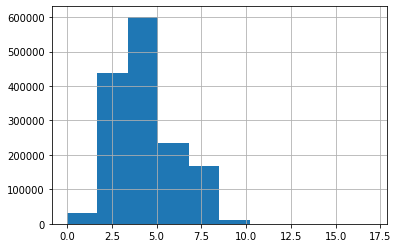

In [87]:
train2.seq_name.apply(lambda x: len(x)).hist()

## Getting maximum number of feature values

In [88]:
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train2.seq_name.max())
                   , np.max(teststg1.seq_name.max())
                  , np.max(train2.seq_item_description.max())
                  , np.max(teststg1.seq_item_description.max())])+2
MAX_CATEGORY = np.max([train2.category_name.max(), teststg1.category_name.max()])+1
MAX_BRAND = np.max([train2.brand_name.max(), teststg1.brand_name.max()])+1
MAX_CONDITION = np.max([train2.item_condition_id.max(), teststg1.item_condition_id.max()])+1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd3dfd57c10>]],
      dtype=object)

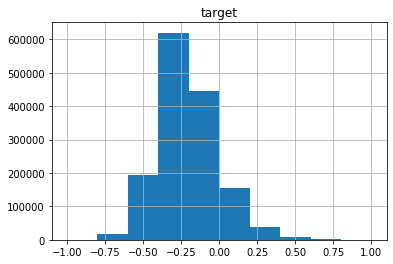

In [89]:
#SCALE target variable
train2["target"] = np.log(train2.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1)) 
train2["target"] = target_scaler.fit_transform(np.array(train2['target']).reshape(-1,1))
pd.DataFrame(train2.target).hist()

In [90]:
train2.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'general_cat', 'subcat_1',
       'subcat_2', 'desclength', 'seq_item_description', 'seq_name', 'target'],
      dtype='object')

## Train Test splitting

In [91]:
dtrain, dvalid = train_test_split(train2, random_state=120, train_size=0.95)
print(dtrain.shape)
print(dvalid.shape)

(1408408, 15)
(74127, 15)


In [92]:
dtrain.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'general_cat', 'subcat_1',
       'subcat_2', 'desclength', 'seq_item_description', 'seq_name', 'target'],
      dtype='object')

In [93]:
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        ,'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ)
        ,'brand_name': np.array(dataset.brand_name) 
        ,'category_name':np.array(dataset.category_name)
        ,'subcat_1':np.array(dataset.subcat_1)
        ,'general_cat':np.array(dataset.general_cat)
        ,'subcat_2':np.array(dataset.subcat_2)
        ,'item_condition': np.array(dataset.item_condition_id)
        ,'num_vars': np.array(dataset[["shipping"]])
        ,'desclength': np.array(dataset[['desclength']])
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(teststg1)

In [94]:
#KERAS MODEL DEFINITION 
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))


In [95]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import tensorflow as tf

In [96]:
def get_model():
    #params
    dr_r = 0.1
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    desclen=Input(shape=[1], name="desclength")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 150)(name)
    emb_item_desc = Embedding(MAX_TEXT,300)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 150)(brand_name)
    emb_cat = Embedding(MAX_CATEGORY, 150)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 150)(item_condition)
    
    #rnn layer
    rnn_layer1 =Bidirectional(LSTM(16)) (emb_item_desc)
    rnn_layer2 =Bidirectional(LSTM(10)) (emb_name)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name),
         Flatten() (emb_cat)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        ,desclen
        , num_vars
    ])

    
    main_l = Dropout(dr_r) (Dense(164) (main_l))
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    
    
    
    #model
    model = Model([name, item_desc, brand_name,
                   desclen, category_name,item_condition,num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
category_name (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
item_condition (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          (None, 75)           0                                            
____________________________________________________________________________________________

In [97]:
print(5)

5


In [98]:
print(5)

5


In [ ]:
%%time
BATCH_SIZE = 14000 
epochs = 7
model = get_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target) , verbose=1)
model.save('my_model_1') 
model.save('my_model_1.model')
model.save('my_model_1.h5')
model.save_weights('my_model_weights_1.h5')

In [100]:
print(5)

5


In [ ]:
import joblib
from tensorflow.keras.models import load_model
#from keras.models import load_model
loaded_model = load_model('model1save2')

In [ ]:
BATCH_SIZE = 14000

In [ ]:
preds = loaded_model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

In [ ]:
model1 = build_model()
model1.save_weights('my_weights.model')

In [100]:
print(5)

5


In [59]:
'''def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<=0 or real[x]<=0: #check for negative values
            continue 
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5'''


import math
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [60]:
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)-1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

 RMSLE error on dev test: 0.6013501975647957


In [61]:
val_preds

array([[21.693216],
       [14.85327 ],
       [24.691214],
       ...,
       [23.994423],
       [14.278912],
       [23.56092 ]], dtype=float32)

In [62]:
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds) 
preds = np.exp(preds)-1

In [63]:
preds.shape

(3460725, 1)

In [ ]:
#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

In [64]:
preds

array([[14.104292],
       [13.914757],
       [45.906094],
       ...,
       [18.440542],
       [20.520828],
       [26.567848]], dtype=float32)

In [65]:
sub=pd.DataFrame()

In [66]:
sub['test_id']=teststg1['test_id']

In [67]:
sub['price']=preds

In [68]:
sw=sub.to_csv('sub29.csv')

In [78]:
sub=pd.DataFrame()

In [79]:
sub['test_id']=teststg1['test_id']

In [80]:
sub['price']=preds

In [82]:
sw=sub.to_csv('sub25.csv')

In [8]:

df=pd.DataFrame()

In [9]:
df['price']=d3
df['test_id']=d2['test_id']
df.head()

,price,test_id
0,9.708641,0
1,11.048950,1
2,39.673341,2
3,14.451112,3
4,9.453781,4


## Model 2

In [64]:
teststg2.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2,desc
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,Unknown,1,Size 7,Women,Jewelry,Rings,b'size'
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,Unknown,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,b'pcs new kraft bubbl mailer line bubbl wrap p...
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,b'brand new coach bag bought coach outlet'
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,Unknown,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,b'kimono worn perfect hot weather'
4,4,Life after Death,3,Other/Books/Religion & Spirituality,Unknown,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,b'rediscov life loss love one toni cook paperb...


In [63]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Unknown,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Unknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Unknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [64]:
print(5)

5


In [22]:
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.feature_extraction.text import CountVectorizer
import re
import gc
from nltk.util import ngrams
from sklearn import preprocessing
from itertools import combinations
from scipy.sparse import csr_matrix, hstack
import time
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dropout, Dense, concatenate, PReLU, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from keras.initializers import he_uniform
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import keras.backend as K

In [23]:
sample = pd.concat([train.drop(columns=["price"], axis=0), teststg2], axis=0)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [24]:
sample.head()

,brand_name,category_name,general_cat,item_condition_id,item_description,name,shipping,subcat_1,subcat_2,test_id,train_id
0,Unknown,Men/Tops/T-shirts,Men,3,No description yet,MLB Cincinnati Reds T Shirt Size XL,1,Tops,T-shirts,NaN,0.0
1,Razer,Electronics/Computers & Tablets/Components & P...,Electronics,3,This keyboard is in great condition and works ...,Razer BlackWidow Chroma Keyboard,0,Computers & Tablets,Components & Parts,NaN,1.0
2,Target,Women/Tops & Blouses/Blouse,Women,1,Adorable top with a hint of lace and a key hol...,AVA-VIV Blouse,1,Tops & Blouses,Blouse,NaN,2.0
3,Unknown,Home/Home Décor/Home Décor Accents,Home,1,New with tags. Leather horses. Retail for [rm]...,Leather Horse Statues,1,Home Décor,Home Décor Accents,NaN,3.0
4,Unknown,Women/Jewelry/Necklaces,Women,1,Complete with certificate of authenticity,24K GOLD plated rose,0,Jewelry,Necklaces,NaN,4.0


In [25]:
from sklearn import preprocessing
from itertools import combinations
from scipy.sparse import csr_matrix, hstack
import time

In [26]:
def clean_str(text, max_text_length=60):
    
    
    
    try:
        
        text = ' '.join([w for w in text.split()[:max_text_length]] )        
        text = text.lower()
        
        text = re.sub(u"é", u"e", text)
        text = re.sub(u"ē", u"e", text)
        text = re.sub(u"è", u"e", text)
        text = re.sub(u"ê", u"e", text)
        text = re.sub(u"à", u"a", text)
        text = re.sub(u"â", u"a", text)
        text = re.sub(u"ô", u"o", text)
        text = re.sub(u"ō", u"o", text)
        text = re.sub(u"ü", u"u", text)
        text = re.sub(u"ï", u"i", text)
        text = re.sub(u"ç", u"c", text)
        text = re.sub(u"\u2019", u"'", text)
        text = re.sub(u"\xed", u"i", text)
        
        text = re.sub(u"w\/", u" with ", text)
        
       
        text = re.sub(u"[^a-z0-9]", " ", text)
      
        text = u" ".join(re.split('(\d+)',text))
        
        text = re.sub( u"\s+", u" ", text).strip()
    except:
        text = np.NaN
        
    return text


In [27]:
def clean_str_df(x):
    return x.apply(lambda y: clean_str(y))

In [28]:
sample["item_description"] = sample["item_description"].apply(clean_str)

In [29]:
sample['item_description'].head()

0                                   no description yet
1    this keyboard is in great condition and works ...
2    adorable top with a hint of lace and a key hol...
3    new with tags leather horses retail for rm eac...
4            complete with certificate of authenticity
Name: item_description, dtype: object

In [30]:
for x in ['brand_name', 'category_name', 'general_cat', 'subcat_1', 
                  'subcat_2']:
            le = preprocessing.LabelEncoder()
            sample[x] = le.fit_transform(sample[x])

In [31]:
'''sample["item_condition_id"] = 1.0 * sample["item_condition_id"] / 5
sample["old_name"] = sample["name"].copy()
sample["brand_cat"] = sample["general_cat"].astype(str) + " " + \
                    "cat2_" + sample["subcat_1"].astype(str) + " " + \
                    "cat3_" +  sample["subcat_2"].astype(str) + " " + \
                    "brand_" + sample["brand_name"].astype(str)
sample["name"] = sample["brand_cat"] + " " + sample["name"]
sample["name_desc"] = sample["name"] + " " + sample["item_description"].apply(lambda x: " ".join(x.split()[:5]))'''

'sample["item_condition_id"] = 1.0 * sample["item_condition_id"] / 5\nsample["old_name"] = sample["name"].copy()\nsample["brand_cat"] = sample["general_cat"].astype(str) + " " +                     "cat2_" + sample["subcat_1"].astype(str) + " " +                     "cat3_" +  sample["subcat_2"].astype(str) + " " +                     "brand_" + sample["brand_name"].astype(str)\nsample["name"] = sample["brand_cat"] + " " + sample["name"]\nsample["name_desc"] = sample["name"] + " " + sample["item_description"].apply(lambda x: " ".join(x.split()[:5]))'

In [32]:
sample["item_condition_id"] = 1.0 * sample["item_condition_id"] / 5
sample["old_name"] = sample["name"].copy()
sample["brand_cat"] = sample["general_cat"].astype(str) + " "  + sample["subcat_1"].astype(str) + " " +  sample["subcat_2"].astype(str) + " " + sample["brand_name"].astype(str)
sample["name"] = sample["brand_cat"] + " " + sample["name"]
sample["name_desc"] = sample["name"] + " " + sample["item_description"].apply(lambda x: " ".join(x.split()[:5]))
    

In [33]:
print(5)

5


In [34]:
split_num = train.shape[0]

In [35]:
split_num

1482535

## Vectorizing the data

In [36]:
vectorizer_brandcat = CountVectorizer(lowercase=True,
                                     ngram_range=(1, 3),dtype=np.int8, min_df=2, max_features=100000, 
                                     binary=True)
#vectorizer_brandcat.fit(sample[:split_num]['brand_cat'])
#pickle.dump(vectorizer_brandcat, open("brandcat.pickel", 'wb'))
brcatvec = pickle.load(open("brandcat.pickel", "rb"))
sparse_data_brandcat = brcatvec.transform(sample['brand_cat'])
del vectorizer_brandcat
sample.drop(columns=["brand_cat"], inplace=True) 

In [37]:
print(5)

5


In [38]:
sample.shape

(4943260, 13)

In [39]:
print("old_name")
vectorizer_name = CountVectorizer(lowercase=True, analyzer="char", 
                                     ngram_range=(2, 4), min_df=5, max_features=100000, 
                                     binary=True,dtype=np.int8)
#vectorizer_name.fit(sample[:train.shape[0]]['old_name'])
#pickle.dump(vectorizer_name, open("name.pickel", 'wb'))
name = pickle.load(open("name.pickel", "rb"))
sparse_data_name = name.transform(sample['old_name'])
del vectorizer_name
sample.drop(columns=["old_name"], inplace=True)


old_name


In [40]:
print("item_description")
vectorizer_desc = CountVectorizer(lowercase=True, stop_words="english",
                                     ngram_range=(1, 2), min_df=20, max_features=100000, dtype=np.int8,
                                     binary=True)
#vectorizer_desc.fit(sample[:train.shape[0]]["item_description"])
#pickle.dump(vectorizer_desc, open("desc.pickel", 'wb'))
desc = pickle.load(open("desc.pickel", "rb"))
sparse_data_desc = desc.transform(sample['item_description'])
del vectorizer_desc
#sample.drop(columns=["item_description"], inplace=True)

item_description


In [41]:
def lg(text):
    text = [x for x in text.split() if x != '']
    return len(text)

In [42]:
train_new = sample[:train.shape[0]].copy()
train_new["price"] = train["price"]
for x in ['category_name', 'subcat_1', 'subcat_2', 'category_name', 'brand_name']:
    tmp = train_new.groupby(x)["price"].mean().astype(np.float32)
    sample['mean_price_' + x] = sample[x].map(tmp).astype(np.float32)
    sample['mean_price_' + x].fillna(tmp.mean(), inplace=True)

In [43]:
sample['nb_words_item_description'] = sample['item_description'].apply(lg).astype(np.int8) 

In [99]:
x = {
           'sparse_data_name': sparse_data_name[:split_num],
           'sparse_data_brandcat': sparse_data_brandcat[:split_num],
           'sparse_data_desc':  sparse_data_desc[:split_num],
           'item_condition': np.array(sample['item_condition_id'])[:split_num],
           'shipping': np.array(sample["shipping"])[:split_num],
           'mean_price_subcat_2': np.array(sample["mean_price_subcat_2"])[:split_num],
           'nb_words_item_description': np.array(sample["nb_words_item_description"])[:split_num]
              }
test = {
           'sparse_data_name': sparse_data_name[split_num:],
           'sparse_data_brandcat':  sparse_data_brandcat[split_num:],
           'sparse_data_desc': sparse_data_desc[split_num:],
           'item_condition': np.array(sample['item_condition_id'])[split_num:],
           'shipping': np.array(sample["shipping"])[split_num:],
           'mean_price_subcat_2': np.array(sample["mean_price_subcat_2"])[split_num:],
           'nb_words_item_description': np.array(sample["nb_words_item_description"])[split_num:]
              }
y = train.price.values

## Defining the model

In [48]:
def model(len_sparse_data_name, len_sparse_data_brandcat, len_sparse_data_desc):
    dr_r=0.1
    sparse_data_name = Input(shape=[len_sparse_data_name], name="sparse_data_name", dtype='float32', 
                             )
    sparse_data_brandcat = Input(shape=[len_sparse_data_brandcat], name="sparse_data_brandcat",
                                 dtype='float32')
    sparse_data_desc = Input(shape=[len_sparse_data_desc], name="sparse_data_desc",
                                 dtype='float32')
    item_condition = Input(shape=[1], name="item_condition", dtype='float32')
    shipping = Input(shape=[1], name="shipping", dtype='float32')
    mean_price_subcat_2 = Input(shape=[1], name="mean_price_subcat_2", 
                                          dtype='float32')
    nb_words_item_description = Input(shape=[1], name="nb_words_item_description", 
                                          dtype='float32')
    
    a = PReLU()(Dense(50)(sparse_data_name))
    b = PReLU()(Dense(50)(sparse_data_brandcat))
    c = PReLU()(Dense(50)(sparse_data_desc)) 
    d = concatenate([a, b, c, item_condition, shipping, mean_price_subcat_2, 
                     nb_words_item_description]) 
    x = PReLU()(Dense(50)(d))
    o = Dense(1,activation="linear")(x)
    m = Model([sparse_data_name, sparse_data_brandcat, sparse_data_desc, 
              item_condition, shipping, mean_price_subcat_2, 
                    nb_words_item_description ], o)

    optimizer = Adam(0.002)
    m.compile(loss="mse", optimizer=optimizer)
    return m

In [49]:
m = model(x["sparse_data_name"].shape[1], x["sparse_data_brandcat"].shape[1],x["sparse_data_desc"].shape[1])
m.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sparse_data_name (InputLayer)   (None, 100000)       0                                            
__________________________________________________________________________________________________
sparse_data_brandcat (InputLaye (None, 44117)        0                                            
__________________________________________________________________________________________________
sparse_data_desc (InputLayer)   (None, 100000)       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           5000050     sparse_data_name[0][0]           
____________________________________________________________________________________________

In [46]:
x

{'item_condition': array([0.6, 0.6, 0.2, ..., 0.4, 0.6, 0.2]),
 'mean_price_subcat_2': array([18.352495, 42.913902, 15.659676, ..., 21.497864, 22.18502 ,
        34.39445 ], dtype=float32),
 'nb_words_item_description': array([ 3, 36, 31, ...,  8, 28, 11], dtype=int8),
 'shipping': array([1, 0, 1, ..., 0, 1, 0]),
 'sparse_data_brandcat': <1482535x44117 sparse matrix of type '<class 'numpy.int8'>'
 	with 8197460 stored elements in Compressed Sparse Row format>,
 'sparse_data_desc': <1482535x100000 sparse matrix of type '<class 'numpy.int8'>'
 	with 28852717 stored elements in Compressed Sparse Row format>,
 'sparse_data_name': <1482535x100000 sparse matrix of type '<class 'numpy.int8'>'
 	with 102313997 stored elements in Compressed Sparse Row format>}

In [ ]:
from scipy import sparse

In [ ]:
f=np.array(x['sparse_data_brandcat'])

In [ ]:
print(5)

In [50]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [51]:
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(np.array(train['target']).reshape(-1,1))

In [52]:
y=train['target']

## Fitting the model

In [ ]:
m.fit(x, y ,epochs=4)

In [55]:
m.fit(x, y ,epochs=4)
m.save_weights('my_model_weights.h5')
m.save('my_model')
m.save('my_model1.model')

Epoch 1/4
1482535/1482535 [==============================] - 5626s 4ms/step - loss: 0.0188
Epoch 2/4
1482535/1482535 [==============================] - 5611s 4ms/step - loss: 0.0128
Epoch 3/4
1482535/1482535 [==============================] - 5571s 4ms/step - loss: 0.0111
Epoch 4/4
1482535/1482535 [==============================] - 5697s 4ms/step - loss: 0.0097


In [48]:
m.save_weights('my_model_weights.h5')
m.save('my_model')
m.save('my_model1.model')

In [56]:
pred = m.predict(test)  

In [57]:
pred

array([[-0.5448851 ],
       [-0.46478933],
       [ 0.16532   ],
       ...,
       [-0.2530167 ],
       [-0.19493237],
       [-0.1688368 ]], dtype=float32)

In [ ]:
#df1=pd.DataFrame()

In [ ]:


#df1['values']=pred

In [ ]:
#pred.to_csv('df5.csv',index=False)

In [ ]:
#pred = m.predict(test)  

In [52]:
pred

array([[-0.45367587],
       [-0.37165475],
       [ 0.15910368],
       ...,
       [-0.30310422],
       [-0.19083488],
       [-0.16048948]], dtype=float32)

In [53]:
print(5)

5


In [58]:
pred = target_scaler.inverse_transform(pred)
pred = np.exp(pred)-1

In [59]:
pred

array([[ 4.6450377],
       [ 6.655136 ],
       [83.06983  ],
       ...,
       [16.128374 ],
       [20.362309 ],
       [22.591063 ]], dtype=float32)

In [60]:
print(5)

5


In [61]:
df=pd.DataFrame()
df['test_id']=teststg2['test_id']
df['price']=pred

In [62]:
df.shape

(3460725, 2)

In [63]:
df.to_csv("submission60.csv",index=False)

# FINAL CODE

## Taking inputs

In [12]:
import numpy as np
import pandas as pd
import gensim
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import warnings
#warnings.filterwarnings("ignore")
import shutil
import os
import pickle
from sklearn.manifold import TSNE
import multiprocessing
import codecs
import random as r

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from gensim.scripts.glove2word2vec import glove2word2vec 
from sklearn.feature_extraction.text import TfidfVectorizer   
from sklearn.feature_extraction.text import CountVectorizer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import math

In [13]:
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.feature_extraction.text import CountVectorizer
import re
import gc
from nltk.util import ngrams
from sklearn import preprocessing
from itertools import combinations
from scipy.sparse import csr_matrix, hstack
import time
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dropout, Dense, concatenate, PReLU, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from keras.initializers import he_uniform
import keras.backend.tensorflow_backend as KTF
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import keras.backend as K
from sklearn import preprocessing
from itertools import combinations
from scipy.sparse import csr_matrix, hstack
import time

from sklearn import preprocessing
from itertools import combinations
from scipy.sparse import csr_matrix, hstack
import time

Using TensorFlow backend.


In [15]:
def inputs():
    train=pd.read_csv('train.tsv',sep='\t')
    teststg2=pd.read_csv('teststg2.tsv',sep='\t')
    return train,teststg2

## Processing

In [6]:
train=pd.read_csv('train.tsv',sep='\t')
teststg2=pd.read_csv('teststg2.tsv',sep='\t')

In [7]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [8]:
teststg2.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [9]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

## Output function

In [15]:
def final1():

#Taking inputs
    train,teststg2=inputs()
   
    #Filling missing data
    def fill_missing_data(data):
        data.category_name.fillna(value = "Other/Other/Other", inplace = True)
        data.brand_name.fillna(value = "Unknown", inplace = True)
        data.item_description.fillna(value = "No description yet", inplace = True)
        return data
    train=fill_missing_data(train)
    train.isnull().sum()
#There are no null values now in the dataset so that we can move on further

    def fill_missing_data(data):
        data.category_name.fillna(value = "Other/Other/Other", inplace = True)
        data.brand_name.fillna(value = "Unknown", inplace = True)
        data.item_description.fillna(value = "No description yet", inplace = True)
        return data    
    teststg2=fill_missing_data(teststg2)
    

#Splitting based on categories i.e splitting categories to sub-catgeory.    
    
    def split_cat(text):
        try: return text.split("/")
        except: return ("No Label", "No Label", "No Label") 
    
    train['general_cat'], train['subcat_1'], train['subcat_2'] = \
    zip(*train['category_name'].apply(lambda x: split_cat(x)))
 
    
    def split_cat(text):
        try: return text.split("/")
        except: return ("No Label", "No Label", "No Label") 
    
    teststg2['general_cat'], teststg2['subcat_1'], teststg2['subcat_2'] = \
    zip(*teststg2['category_name'].apply(lambda x: split_cat(x)))
    
#code for preprocessing the data    
    import nltk
    nltk.download('stopwords')

    
    
    stop = set(stopwords.words('english')) #set of stopwords
    sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
    def cleanhtml(sentence): #function to clean the word of any html-tags
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, ' ', sentence)
        return cleantext
    def cleanpunc(sentence): #function to clean the word of any punctuationor special characters
        cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
        cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
        return cleaned
        print(stop)
        print('************************************')
        


    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in teststg2['item_description'].values:
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (teststg2['item_description'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(teststg2['item_description'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
    #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words  
    #print("***********************************************************************")
    
        final_string.append(str1)
        i+=1
        
    teststg2['desc']=final_string
    
#Finding the length of item_description to use a feature
    lenofdesc=[]
    for i in teststg2['desc']:
        lenofdesc.append(len(i))
    teststg2['desclength']=lenofdesc
    
    lenofdesc1=[]
    for i in train['item_description']:
        lenofdesc1.append(len(i))
    train['desclength']=lenofdesc1
      

        
        
        
        
        
        
# The second pipeline for the data

    train2=train
    #teststg2=teststg1
   # train,teststg2=inputs()
    sample = pd.concat([train2.drop(columns=["price"], axis=0), teststg2], axis=0)

    def clean_str_df(x):
        return x.apply(lambda y: clean_str(y))

#Using labelEncoder
    for x in ['brand_name', 'category_name', 'general_cat', 'subcat_1', 
                  'subcat_2']:
        le= preprocessing.LabelEncoder()
        sample[x] = le.fit_transform(sample[x])

    sample["item_condition_id"] = 1.0 * sample["item_condition_id"] / 5
    sample["old_name"] = sample["name"].copy()
    sample["brand_cat"] = sample["general_cat"].astype(str) + " "  + sample["subcat_1"].astype(str) + " " + sample["subcat_2"].astype(str) + " " + sample["brand_name"].astype(str)
    sample["name"] = sample["brand_cat"] + " " + sample["name"]
    sample["name_desc"] = sample["name"] + " " + sample["item_description"].apply(lambda x: " ".join(x.split()[:5]))
    
    split_num = train2.shape[0]

#Function to find the number of words of description
    def lg(text):
        text = [x for x in text.split() if x != '']
        return len(text)
    
    train2['nb_words_item_description'] = train2['item_description'].apply(lg).astype(np.int32) 
#I have used the cleaned teststg2 description data.
    teststg2['nb_words_item_description'] = teststg2['desc'].apply(lg).astype(np.int32)     
    
#Intializing CountVectorizer for the above data, name and description 

    vectorizer_brandcat = CountVectorizer(lowercase=True,
                                     ngram_range=(1, 3),dtype=np.int8, min_df=2, max_features=100000, 
                                     binary=True)
    vectorizer_brandcat.fit(sample[:split_num]['brand_cat'])
    sparse_data_brandcat = vectorizer_brandcat.transform(sample['brand_cat'])
    del vectorizer_brandcat
    sample.drop(columns=["brand_cat"], inplace=True) 

    print("old_name")
    vectorizer_name = CountVectorizer(lowercase=True, analyzer="char", 
                                     ngram_range=(2, 4), min_df=5, max_features=100000, 
                                     binary=True,dtype=np.int8)
    vectorizer_name.fit(sample[:train.shape[0]]['old_name'])
    sparse_data_name = vectorizer_name.transform(sample['old_name'])
    del vectorizer_name
    sample.drop(columns=["old_name"], inplace=True)


    print("item_description")
    vectorizer_desc = CountVectorizer(lowercase=True, stop_words="english",
                                     ngram_range=(1, 2), min_df=20, max_features=100000, dtype=np.int8,
                                     binary=True)
    vectorizer_desc.fit(sample[:train.shape[0]]["item_description"])
    sparse_data_desc = vectorizer_desc.transform(sample['item_description'])
    del vectorizer_desc
    #sample.drop(columns=["item_description"], inplace=True)

    train_new = sample[:train.shape[0]].copy()
    train_new["price"] = train["price"]
    for x in ['category_name', 'subcat_1', 'subcat_2', 'category_name', 'brand_name'  ]:
        tmp = train_new.groupby(x)["price"].mean().astype(np.float32)
        sample['mean_price_' + x] = sample[x].map(tmp).astype(np.float32)
        sample['mean_price_' + x].fillna(tmp.mean(), inplace=True)

    sample['nb_words_item_description'] = sample['item_description'].apply(lg).astype(np.int8) 

#Splitting the data to train and test
    
    x = {
           'sparse_data_name': sparse_data_name[:split_num],
           'sparse_data_brandcat': sparse_data_brandcat[:split_num],
           'sparse_data_desc':  sparse_data_desc[:split_num],
           'item_condition': np.array(sample['item_condition_id'])[:split_num],
           'shipping': np.array(sample["shipping"])[:split_num],
           'mean_price_subcat_2': np.array(sample["mean_price_subcat_2"])[:split_num],
           'nb_words_item_description': np.array(sample["nb_words_item_description"])[:split_num]
              }
    
    test = {
           'sparse_data_name': sparse_data_name[split_num:],
           'sparse_data_brandcat':  sparse_data_brandcat[split_num:],
           'sparse_data_desc': sparse_data_desc[split_num:],
           'item_condition': np.array(sample['item_condition_id'])[split_num:],
           'shipping': np.array(sample["shipping"])[split_num:],
           'mean_price_subcat_2': np.array(sample["mean_price_subcat_2"])[split_num:],
           'nb_words_item_description': np.array(sample["nb_words_item_description"])[split_num:]
              }
    y = train.price.values

#defining the model.

    def model(len_sparse_data_name, len_sparse_data_brandcat, len_sparse_data_desc):
        dr_r=0.1
        sparse_data_name = Input(shape=[len_sparse_data_name], name="sparse_data_name", dtype='float32', 
                             )
        sparse_data_brandcat = Input(shape=[len_sparse_data_brandcat], name="sparse_data_brandcat",
                                 dtype='float32')
        sparse_data_desc = Input(shape=[len_sparse_data_desc], name="sparse_data_desc",
                                 dtype='float32')
        item_condition = Input(shape=[1], name="item_condition", dtype='float32')
        shipping = Input(shape=[1], name="shipping", dtype='float32')
        mean_price_subcat_2 = Input(shape=[1], name="mean_price_subcat_2", 
                                          dtype='float32')
        nb_words_item_description = Input(shape=[1], name="nb_words_item_description", 
                                          dtype='float32')
    
        a = PReLU()(Dense(50)(sparse_data_name))
        b = PReLU()(Dense(50)(sparse_data_brandcat))
        c = PReLU()(Dense(50)(sparse_data_desc)) 
        d = concatenate([a, b, c, item_condition, shipping, mean_price_subcat_2, 
                     nb_words_item_description]) 
        x = PReLU()(Dense(51)(d))
        o = Dense(1,activation="linear")(x)
        m = Model([sparse_data_name, sparse_data_brandcat, sparse_data_desc, 
              item_condition, shipping, mean_price_subcat_2, 
                    nb_words_item_description ], o)

        optimizer = Adam(0.002)
        m.compile(loss="mse", optimizer=optimizer)
        return m

    
    print(57)    
    

    model2 = model(x["sparse_data_name"].shape[1], x["sparse_data_brandcat"].shape[1],x["sparse_data_desc"].shape[1])
    model2.summary() 

    train["target"] = np.log(train.price+1)
    target_scaler = MinMaxScaler(feature_range=(-1, 1))
    train["target"] = target_scaler.fit_transform(np.array(train['target']).reshape(-1,1))

#fitting the model
    y=train['target']
    model2.fit(x, y ,epochs=4)
    pickle.dump(model2, open('model2weights', 'wb'))
    #loaded_model = pickle.load(open(filename, 'rb'))
    pred = model2.predict(test)  
    pred.shape

    pred = target_scaler.inverse_transform(pred)
    pred = np.exp(pred)-1

    df=pd.DataFrame()
    df['test_id']=teststg2['test_id']
    df['price']=pred

    df.to_csv("submissionc.csv",index=False)
    
#calculating the weighted-average of the data    
    d1=pd.read_csv("submissionf2.csv")
    d2=pd.read_csv("submission.csv")
    d3=d1['price']*0.4+d2['price']*0.6
    df=pd.DataFrame()

    df['price']=d3
    df['test_id']=d2['test_id']
    df.head()

    df.to_csv('submission5.csv',index=False)
 
        

In [16]:
final1()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/praneethic1101/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



old_name
item_description
57
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sparse_data_name (InputLayer)   (None, 100000)       0                                            
__________________________________________________________________________________________________
sparse_data_brandcat (InputLaye (None, 44117)        0                                            
__________________________________________________________________________________________________
sparse_data_desc (InputLayer)   (None, 100000)       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           5000050     sparse_data_name[0][0]           
_______________________________________________________________

In [19]:
print(5)

5


In [1]:
import pandas as pd

In [2]:
d1=pd.read_csv("submissionf2.csv")

In [3]:
d2=pd.read_csv("submission.csv")

In [4]:
d1.head()

,Unnamed: 0,test_id,price
0,0,0,8.918736
1,1,1,12.056746
2,2,2,38.146890
3,3,3,15.362528
4,4,4,7.486397


In [5]:
d2.head()

,Unnamed: 0,test_id,price
0,0,0,10.235245
1,1,1,10.377086
2,2,2,40.690975
3,3,3,13.843502
4,4,4,10.765371


In [6]:
d3=d1['price']*0.4+d2['price']*0.6

In [7]:
d3

0           9.708641
1          11.048950
2          39.673341
3          14.451112
4           9.453781
             ...    
3460720     9.005241
3460721    57.915544
3460722    16.683711
3460723    14.457055
3460724    19.927568
Name: price, Length: 3460725, dtype: float64

In [1]:
print(5)

5


## Conclusion

**Therefore, we have tried three methods i.e one using LGBM and the other two using deep learning models.
We got a very good score for both the deep learning models. Finally, we have used weighted average method and increased the final RMSLE score.The price we predicted also got a nearer value with respect to the original.** 